In [1]:
%%capture
!pip install tables
!pip install --upgrade --force-reinstall tensorflow
!pip install keras-tuner
import os, gc, pickle, datetime, scipy.sparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style

from sklearn.model_selection import GroupKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from cycler import cycler
from IPython.display import display

import scipy.sparse
import scprep

def correlation_score(y_true, y_pred):
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(y_true.shape[0]):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)

def negative_correlation_loss(y_true, y_pred):
    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, tf.shape(y_true)[1]))
    ym = y_pred - my
    r_num = K.sum(tf.multiply(y_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * float(tf.shape(y_true)[-1]))
    r = tf.reduce_mean(r_num / r_den)
    return - r

from sklearn.model_selection import train_test_split
import scprep

import math
import tensorflow as tf
import keras_tuner
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout, BatchNormalization
LR_START = 0.01
BATCH_SIZE = 512

best_hp = keras_tuner.HyperParameters()
best_hp.values = {'reg1': 0.0001,
                'reg2': 3.307e-07,
                'units1': 1024,
                'units2': 1024,
                'units3': 1024,
                'lr': 0.001
                 }

def create_model(hp=best_hp):
    
    #reg1 = 8e-5
    #reg2 = 2e-5
    # reg1 = 9.613e-06
    # reg2 = 1e-07
    reg1 = hp.Float("reg1", min_value=1e-8, max_value=1e-4, sampling="log")
    reg2 = hp.Float("reg2", min_value=1e-8, max_value=1e-4, sampling="log")
    
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(X.shape[1],))

    x0 = Dense(hp.Choice('units1', [1024,512,256]), 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    
    x1 = Dense(hp.Choice('units2', [1024,512,256]), 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = Dropout(DROP)(x1)
    
    x2 = Dense(hp.Choice('units3', [1024,512,256]), 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= Dropout(DROP)(x2)

    x = Concatenate()([
                x0, 
                x1, 
                x2
                ])
    x = Dense(Y.shape[1], 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    model = Model(inputs, x)
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-3, max_value=1e-0)),
        metrics = [negative_correlation_loss],
        loss = 'mse'
         )
    return model

2022-11-15 23:35:35.601929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 23:35:35.721410: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-15 23:35:35.758208: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-15 23:35:36.326985: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [8]:
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta_t = metadata_df.reindex(cell_index_t)

In [9]:
meta_t

,day,donor,cell_type,technology
cell_id,,,,
458c2ae2c9b1,2,27678,hidden,multiome
01a0659b0710,2,27678,hidden,multiome
028a8bc3f2ba,2,27678,hidden,multiome
7ec0ca8bb863,2,27678,hidden,multiome
caa0b0022cdc,2,27678,hidden,multiome
...,...,...,...,...
96a60b026659,10,31800,hidden,multiome
d493e546991e,10,31800,hidden,multiome
05666c99aa48,10,31800,hidden,multiome


In [10]:
meta_t.donor.unique()

array([27678, 32606, 13176, 31800])

In [129]:
def evaluate(i,j,loss,save):
    VERBOSE = 0
    if loss:
        N_SPLIT = 6
    else:
        N_SPLIT = 3
    #kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
    kf = KFold(n_splits = N_SPLIT)

    scores = []
    pca_scores = []
    Y_pred = np.zeros_like(Y)

    for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

        X_tr = X[idx_tr]
        y_tr = Y[idx_tr]

        X_va = X[idx_va]
        y_va = Y[idx_va] 

        model = create_model()

        lr = ReduceLROnPlateau(
                    monitor = "val_loss",
                    factor = 0.9, 
                    patience = 4, 
                    verbose = VERBOSE)

        es = EarlyStopping(
                    monitor = "val_loss",
                    patience = 30, 
                    verbose = VERBOSE,
                    mode = "min", 
                    restore_best_weights = True)

        if loss:
            chk = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './cite',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)
        else:
            chk = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './multi',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)

        if loss:
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                      loss = negative_correlation_loss,
                      metrics=negative_correlation_loss)
        else:    
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                      loss = 'mse',
                      metrics=None)
        model.fit(X_tr,
                  y_tr,
                  validation_data=(X_va,y_va),
                  epochs =500,
                  verbose = VERBOSE,
                  batch_size=256,
                  callbacks = [es,lr,chk]
                 )
        y_va_pred = model.predict(X_va)
        Y_pred[idx_va] = y_va_pred
        if loss:
            corrscore = correlation_score(y_va, y_va_pred)
            scores.append(corrscore)

        else:
            corrscore = correlation_score(targets[idx_va], y_va_pred@svd.components_[:64])
            scores.append(corrscore)
            pca_corrscore = correlation_score(y_va[:,:64], y_va_pred[:,:64])
            pca_scores.append(pca_corrscore)

        if loss:    
            model.fit(X_va,
                  y_va,
                  epochs=20,
                  verbose = VERBOSE,
                  batch_size=256
                 )    
            
        print(f'\n --------- FOLD {fold} -----------')
        if not loss:
            print(f'Mean squared error = {np.round(mean_squared_error(y_va,y_va_pred),2)}')
        print(f'Correlation = {corrscore:.5f}')
        if not loss:
            print(f'PCA Correlation = {pca_corrscore:.5f}')
        if loss:
           filename = f"./cite_model_saves/model_{i}_{j}_{fold}"
        else:
           filename = f"./multi_model_saves/model_{i}_{j}_{fold}"
        if save:
            model.save(filename)
            print('model saved :',filename)

        del X_tr,X_va,y_tr,y_va
        gc.collect()

    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Mean corr = {np.array(scores).mean():.5f}{Style.RESET_ALL}")
    if not loss:
        print(f"{Fore.RED}{Style.BRIGHT}Mean pca corr = {np.array(pca_scores).mean():.5f}{Style.RESET_ALL}")

In [78]:
import warnings
warnings.filterwarnings("ignore")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
for i in (2,3,4,7):
    for j in (32606,13176,31800):
        selector[(i,j)] = meta.loc[(meta.day == i)&(meta.donor == j)].range.values

In [20]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]
for (i,j) in selector.keys():
    targets = targets_copy.copy()
    X = X_copy.copy()
    targets = targets[selector[(i,j)]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy[selector[(i,j)]]
    evaluate(i,j)

2022-11-07 20:14:33.505281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-07 20:14:33.512074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-07 20:14:33.512095: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-07 20:14:33.512498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

76/76 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 6.630000114440918
Correlation = 0.69091
PCA Correlation = 0.98118
model saved : ./model_saves/model_2_32606_0
76/76 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 6.75
Correlation = 0.68947
PCA Correlation = 0.98085
model saved : ./model_saves/model_2_32606_1
76/76 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 6.78000020980835
Correlation = 0.68782
PCA Correlation = 0.98065
model saved : ./model_saves/model_2_32606_2
Mean corr = 0.68940
Mean pca corr = 0.98089
100/100 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 6.179999828338623
Correlation = 0.67942
PCA Correlation = 0.98182
model saved : ./model_saves/model_2_13176_0
100/100 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 6

In [3]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
for (i,j) in selector.keys():
    targets = targets_copy.copy()
    targets = targets[selector[(i,j)]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    svd = TruncatedSVD(n_components = 128,random_state = 1)
    svd.fit(targets)
    np.save(f'./multi_model_saves/model_{i}_{j}_svds',svd.components_[:64])

In [21]:
model = load_model(f"./model_saves/model_7_13176_2",
                        custom_objects={'negative_correlation_loss': negative_correlation_loss})

In [24]:
targets = targets_copy.copy()
X = X_copy.copy()
targets = targets[selector[(7,31800)]]
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)
targets = np.array(targets)
svd = TruncatedSVD(n_components = 512,random_state = 1)
Y = svd.fit_transform(targets)[:,:64]
corrscore = correlation_score(targets, model.predict(X_copy[selector[(7,31800)]])@svd.components_[:64])
print(corrscore)

240/240 [==============================] - 1s 2ms/step
0.6079187836146946


In [2]:
# constant_cols = list(X.columns[(X == 0).all(axis=0).values]) + list(X_test.columns[(X_test == 0).all(axis=0).values])
constant_cols = ['ENSG00000003137_CYP26B1', 'ENSG00000004848_ARX', 'ENSG00000006606_CCL26', 'ENSG00000010379_SLC6A13', 'ENSG00000010932_FMO1', 'ENSG00000017427_IGF1', 'ENSG00000022355_GABRA1', 'ENSG00000041982_TNC', 'ENSG00000060709_RIMBP2', 'ENSG00000064886_CHI3L2', 'ENSG00000065717_TLE2', 'ENSG00000067798_NAV3', 'ENSG00000069535_MAOB', 'ENSG00000073598_FNDC8', 'ENSG00000074219_TEAD2', 'ENSG00000074964_ARHGEF10L', 'ENSG00000077264_PAK3', 'ENSG00000078053_AMPH', 'ENSG00000082684_SEMA5B', 'ENSG00000083857_FAT1', 'ENSG00000084628_NKAIN1', 'ENSG00000084734_GCKR', 'ENSG00000086967_MYBPC2', 'ENSG00000087258_GNAO1', 'ENSG00000089505_CMTM1', 'ENSG00000091129_NRCAM', 'ENSG00000091986_CCDC80', 'ENSG00000092377_TBL1Y', 'ENSG00000092969_TGFB2', 'ENSG00000095397_WHRN', 'ENSG00000095970_TREM2', 'ENSG00000099715_PCDH11Y', 'ENSG00000100197_CYP2D6', 'ENSG00000100218_RSPH14', 'ENSG00000100311_PDGFB', 'ENSG00000100362_PVALB', 'ENSG00000100373_UPK3A', 'ENSG00000100625_SIX4', 'ENSG00000100867_DHRS2', 'ENSG00000100985_MMP9', 'ENSG00000101197_BIRC7', 'ENSG00000101298_SNPH', 'ENSG00000102387_TAF7L', 'ENSG00000103034_NDRG4', 'ENSG00000104059_FAM189A1', 'ENSG00000104112_SCG3', 'ENSG00000104313_EYA1', 'ENSG00000104892_KLC3', 'ENSG00000105088_OLFM2', 'ENSG00000105261_OVOL3', 'ENSG00000105290_APLP1', 'ENSG00000105507_CABP5', 'ENSG00000105642_KCNN1', 'ENSG00000105694_ELOCP28', 'ENSG00000105707_HPN', 'ENSG00000105894_PTN', 'ENSG00000106018_VIPR2', 'ENSG00000106541_AGR2', 'ENSG00000107317_PTGDS', 'ENSG00000108688_CCL7', 'ENSG00000108702_CCL1', 'ENSG00000108947_EFNB3', 'ENSG00000109193_SULT1E1', 'ENSG00000109794_FAM149A', 'ENSG00000109832_DDX25', 'ENSG00000110195_FOLR1', 'ENSG00000110375_UPK2', 'ENSG00000110436_SLC1A2', 'ENSG00000111339_ART4', 'ENSG00000111863_ADTRP', 'ENSG00000112761_WISP3', 'ENSG00000112852_PCDHB2', 'ENSG00000114251_WNT5A', 'ENSG00000114279_FGF12', 'ENSG00000114455_HHLA2', 'ENSG00000114757_PEX5L', 'ENSG00000115155_OTOF', 'ENSG00000115266_APC2', 'ENSG00000115297_TLX2', 'ENSG00000115590_IL1R2', 'ENSG00000115844_DLX2', 'ENSG00000116194_ANGPTL1', 'ENSG00000116661_FBXO2', 'ENSG00000116774_OLFML3', 'ENSG00000117322_CR2', 'ENSG00000117971_CHRNB4', 'ENSG00000118322_ATP10B', 'ENSG00000118402_ELOVL4', 'ENSG00000118520_ARG1', 'ENSG00000118946_PCDH17', 'ENSG00000118972_FGF23', 'ENSG00000119771_KLHL29', 'ENSG00000120549_KIAA1217', 'ENSG00000121316_PLBD1', 'ENSG00000121905_HPCA', 'ENSG00000122224_LY9', 'ENSG00000124194_GDAP1L1', 'ENSG00000124440_HIF3A', 'ENSG00000124657_OR2B6', 'ENSG00000125462_C1orf61', 'ENSG00000125895_TMEM74B', 'ENSG00000126838_PZP', 'ENSG00000128422_KRT17', 'ENSG00000128918_ALDH1A2', 'ENSG00000129170_CSRP3', 'ENSG00000129214_SHBG', 'ENSG00000129673_AANAT', 'ENSG00000129910_CDH15', 'ENSG00000130294_KIF1A', 'ENSG00000130307_USHBP1', 'ENSG00000130545_CRB3', 'ENSG00000131019_ULBP3', 'ENSG00000131044_TTLL9', 'ENSG00000131183_SLC34A1', 'ENSG00000131386_GALNT15', 'ENSG00000131400_NAPSA', 'ENSG00000131914_LIN28A', 'ENSG00000131941_RHPN2', 'ENSG00000131951_LRRC9', 'ENSG00000132170_PPARG', 'ENSG00000132681_ATP1A4', 'ENSG00000132958_TPTE2', 'ENSG00000133454_MYO18B', 'ENSG00000134545_KLRC1', 'ENSG00000134853_PDGFRA', 'ENSG00000135083_CCNJL', 'ENSG00000135100_HNF1A', 'ENSG00000135116_HRK', 'ENSG00000135312_HTR1B', 'ENSG00000135324_MRAP2', 'ENSG00000135436_FAM186B', 'ENSG00000135472_FAIM2', 'ENSG00000135898_GPR55', 'ENSG00000135929_CYP27A1', 'ENSG00000136002_ARHGEF4', 'ENSG00000136099_PCDH8', 'ENSG00000136274_NACAD', 'ENSG00000137078_SIT1', 'ENSG00000137142_IGFBPL1', 'ENSG00000137473_TTC29', 'ENSG00000137474_MYO7A', 'ENSG00000137491_SLCO2B1', 'ENSG00000137691_CFAP300', 'ENSG00000137731_FXYD2', 'ENSG00000137747_TMPRSS13', 'ENSG00000137878_GCOM1', 'ENSG00000138411_HECW2', 'ENSG00000138741_TRPC3', 'ENSG00000138769_CDKL2', 'ENSG00000138823_MTTP', 'ENSG00000139908_TSSK4', 'ENSG00000140832_MARVELD3', 'ENSG00000142178_SIK1', 'ENSG00000142538_PTH2', 'ENSG00000142910_TINAGL1', 'ENSG00000143217_NECTIN4', 'ENSG00000143858_SYT2', 'ENSG00000144130_NT5DC4', 'ENSG00000144214_LYG1', 'ENSG00000144290_SLC4A10', 'ENSG00000144366_GULP1', 'ENSG00000144583_MARCH4', 'ENSG00000144771_LRTM1', 'ENSG00000144891_AGTR1', 'ENSG00000145087_STXBP5L', 'ENSG00000145107_TM4SF19', 'ENSG00000146197_SCUBE3', 'ENSG00000146966_DENND2A', 'ENSG00000147082_CCNB3', 'ENSG00000147614_ATP6V0D2', 'ENSG00000147642_SYBU', 'ENSG00000147869_CER1', 'ENSG00000149403_GRIK4', 'ENSG00000149596_JPH2', 'ENSG00000150630_VEGFC', 'ENSG00000150722_PPP1R1C', 'ENSG00000151631_AKR1C6P', 'ENSG00000151704_KCNJ1', 'ENSG00000152154_TMEM178A', 'ENSG00000152292_SH2D6', 'ENSG00000152315_KCNK13', 'ENSG00000152503_TRIM36', 'ENSG00000153253_SCN3A', 'ENSG00000153902_LGI4', 'ENSG00000153930_ANKFN1', 'ENSG00000154040_CABYR', 'ENSG00000154118_JPH3', 'ENSG00000154175_ABI3BP', 'ENSG00000154645_CHODL', 'ENSG00000157060_SHCBP1L', 'ENSG00000157087_ATP2B2', 'ENSG00000157152_SYN2', 'ENSG00000157168_NRG1', 'ENSG00000157680_DGKI', 'ENSG00000158246_TENT5B', 'ENSG00000158477_CD1A', 'ENSG00000158481_CD1C', 'ENSG00000158488_CD1E', 'ENSG00000159189_C1QC', 'ENSG00000159217_IGF2BP1', 'ENSG00000160683_CXCR5', 'ENSG00000160801_PTH1R', 'ENSG00000160973_FOXH1', 'ENSG00000161594_KLHL10', 'ENSG00000162409_PRKAA2', 'ENSG00000162840_MT2P1', 'ENSG00000162873_KLHDC8A', 'ENSG00000162944_RFTN2', 'ENSG00000162949_CAPN13', 'ENSG00000163116_STPG2', 'ENSG00000163288_GABRB1', 'ENSG00000163531_NFASC', 'ENSG00000163618_CADPS', 'ENSG00000163637_PRICKLE2', 'ENSG00000163735_CXCL5', 'ENSG00000163873_GRIK3', 'ENSG00000163898_LIPH', 'ENSG00000164061_BSN', 'ENSG00000164078_MST1R', 'ENSG00000164123_C4orf45', 'ENSG00000164690_SHH', 'ENSG00000164761_TNFRSF11B', 'ENSG00000164821_DEFA4', 'ENSG00000164845_FAM86FP', 'ENSG00000164867_NOS3', 'ENSG00000166073_GPR176', 'ENSG00000166148_AVPR1A', 'ENSG00000166250_CLMP', 'ENSG00000166257_SCN3B', 'ENSG00000166268_MYRFL', 'ENSG00000166523_CLEC4E', 'ENSG00000166535_A2ML1', 'ENSG00000166819_PLIN1', 'ENSG00000166928_MS4A14', 'ENSG00000167210_LOXHD1', 'ENSG00000167306_MYO5B', 'ENSG00000167634_NLRP7', 'ENSG00000167748_KLK1', 'ENSG00000167889_MGAT5B', 'ENSG00000168140_VASN', 'ENSG00000168546_GFRA2', 'ENSG00000168646_AXIN2', 'ENSG00000168955_TM4SF20', 'ENSG00000168993_CPLX1', 'ENSG00000169075_Z99496.1', 'ENSG00000169194_IL13', 'ENSG00000169246_NPIPB3', 'ENSG00000169884_WNT10B', 'ENSG00000169900_PYDC1', 'ENSG00000170074_FAM153A', 'ENSG00000170075_GPR37L1', 'ENSG00000170289_CNGB3', 'ENSG00000170356_OR2A20P', 'ENSG00000170537_TMC7', 'ENSG00000170689_HOXB9', 'ENSG00000170827_CELP', 'ENSG00000171346_KRT15', 'ENSG00000171368_TPPP', 'ENSG00000171501_OR1N2', 'ENSG00000171532_NEUROD2', 'ENSG00000171611_PTCRA', 'ENSG00000171873_ADRA1D', 'ENSG00000171916_LGALS9C', 'ENSG00000172005_MAL', 'ENSG00000172987_HPSE2', 'ENSG00000173068_BNC2', 'ENSG00000173077_DEC1', 'ENSG00000173210_ABLIM3', 'ENSG00000173267_SNCG', 'ENSG00000173369_C1QB', 'ENSG00000173372_C1QA', 'ENSG00000173391_OLR1', 'ENSG00000173626_TRAPPC3L', 'ENSG00000173698_ADGRG2', 'ENSG00000173868_PHOSPHO1', 'ENSG00000174407_MIR1-1HG', 'ENSG00000174807_CD248', 'ENSG00000175206_NPPA', 'ENSG00000175746_C15orf54', 'ENSG00000175985_PLEKHD1', 'ENSG00000176043_AC007160.1', 'ENSG00000176399_DMRTA1', 'ENSG00000176510_OR10AC1', 'ENSG00000176697_BDNF', 'ENSG00000176826_FKBP9P1', 'ENSG00000176988_FMR1NB', 'ENSG00000177324_BEND2', 'ENSG00000177335_C8orf31', 'ENSG00000177535_OR2B11', 'ENSG00000177614_PGBD5', 'ENSG00000177707_NECTIN3', 'ENSG00000178033_CALHM5', 'ENSG00000178175_ZNF366', 'ENSG00000178462_TUBAL3', 'ENSG00000178732_GP5', 'ENSG00000178750_STX19', 'ENSG00000179058_C9orf50', 'ENSG00000179101_AL590139.1', 'ENSG00000179388_EGR3', 'ENSG00000179611_DGKZP1', 'ENSG00000179899_PHC1P1', 'ENSG00000179934_CCR8', 'ENSG00000180537_RNF182', 'ENSG00000180712_LINC02363', 'ENSG00000180988_OR52N2', 'ENSG00000181001_OR52N1', 'ENSG00000181616_OR52H1', 'ENSG00000181634_TNFSF15', 'ENSG00000182021_AL591379.1', 'ENSG00000182230_FAM153B', 'ENSG00000182853_VMO1', 'ENSG00000183090_FREM3', 'ENSG00000183562_AC131971.1', 'ENSG00000183615_FAM167B', 'ENSG00000183625_CCR3', 'ENSG00000183770_FOXL2', 'ENSG00000183779_ZNF703', 'ENSG00000183831_ANKRD45', 'ENSG00000183844_FAM3B', 'ENSG00000183960_KCNH8', 'ENSG00000184106_TREML3P', 'ENSG00000184227_ACOT1', 'ENSG00000184363_PKP3', 'ENSG00000184434_LRRC19', 'ENSG00000184454_NCMAP', 'ENSG00000184571_PIWIL3', 'ENSG00000184702_SEPT5', 'ENSG00000184908_CLCNKB', 'ENSG00000184923_NUTM2A', 'ENSG00000185070_FLRT2', 'ENSG00000185156_MFSD6L', 'ENSG00000185567_AHNAK2', 'ENSG00000185686_PRAME', 'ENSG00000186190_BPIFB3', 'ENSG00000186191_BPIFB4', 'ENSG00000186231_KLHL32', 'ENSG00000186431_FCAR', 'ENSG00000186715_MST1L', 'ENSG00000187116_LILRA5', 'ENSG00000187185_AC092118.1', 'ENSG00000187268_FAM9C', 'ENSG00000187554_TLR5', 'ENSG00000187867_PALM3', 'ENSG00000188153_COL4A5', 'ENSG00000188158_NHS', 'ENSG00000188163_FAM166A', 'ENSG00000188316_ENO4', 'ENSG00000188959_C9orf152', 'ENSG00000189013_KIR2DL4', 'ENSG00000189409_MMP23B', 'ENSG00000196092_PAX5', 'ENSG00000196260_SFTA2', 'ENSG00000197358_BNIP3P1', 'ENSG00000197446_CYP2F1', 'ENSG00000197540_GZMM', 'ENSG00000198049_AVPR1B', 'ENSG00000198134_AC007537.1', 'ENSG00000198156_NPIPB6', 'ENSG00000198221_AFDN-DT', 'ENSG00000198626_RYR2', 'ENSG00000198759_EGFL6', 'ENSG00000198822_GRM3', 'ENSG00000198963_RORB', 'ENSG00000199090_MIR326', 'ENSG00000199753_SNORD104', 'ENSG00000199787_RF00406', 'ENSG00000199872_RNU6-942P', 'ENSG00000200075_RF00402', 'ENSG00000200296_RNU1-83P', 'ENSG00000200683_RNU6-379P', 'ENSG00000201044_RNU6-268P', 'ENSG00000201343_RF00019', 'ENSG00000201564_RN7SKP50', 'ENSG00000201616_RNU1-91P', 'ENSG00000201737_RNU1-133P', 'ENSG00000202048_SNORD114-20', 'ENSG00000202415_RN7SKP269', 'ENSG00000203395_AC015969.1', 'ENSG00000203721_LINC00862', 'ENSG00000203727_SAMD5', 'ENSG00000203737_GPR52', 'ENSG00000203783_PRR9', 'ENSG00000203867_RBM20', 'ENSG00000203907_OOEP', 'ENSG00000203999_LINC01270', 'ENSG00000204010_IFIT1B', 'ENSG00000204044_SLC12A5-AS1', 'ENSG00000204091_TDRG1', 'ENSG00000204121_ECEL1P1', 'ENSG00000204165_CXorf65', 'ENSG00000204173_LRRC37A5P', 'ENSG00000204248_COL11A2', 'ENSG00000204424_LY6G6F', 'ENSG00000204539_CDSN', 'ENSG00000204583_LRCOL1', 'ENSG00000204677_FAM153C', 'ENSG00000204709_LINC01556', 'ENSG00000204711_C9orf135', 'ENSG00000204792_LINC01291', 'ENSG00000204850_AC011484.1', 'ENSG00000204851_PNMA8B', 'ENSG00000204909_SPINK9', 'ENSG00000205037_AC134312.1', 'ENSG00000205038_PKHD1L1', 'ENSG00000205089_CCNI2', 'ENSG00000205106_DKFZp779M0652', 'ENSG00000205364_MT1M', 'ENSG00000205502_C2CD4B', 'ENSG00000205746_AC126755.1', 'ENSG00000205856_C22orf42', 'ENSG00000206052_DOK6', 'ENSG00000206579_XKR4', 'ENSG00000206645_RF00019', 'ENSG00000206786_RNU6-701P', 'ENSG00000206846_RF00019', 'ENSG00000206848_RNU6-890P', 'ENSG00000207088_SNORA7B', 'ENSG00000207181_SNORA14B', 'ENSG00000207234_RNU6-125P', 'ENSG00000207326_RF00019', 'ENSG00000207359_RNU6-925P', 'ENSG00000211677_IGLC2', 'ENSG00000211699_TRGV3', 'ENSG00000211895_IGHA1', 'ENSG00000212385_RNU6-817P', 'ENSG00000212391_RF00554', 'ENSG00000212607_SNORA3B', 'ENSG00000212829_RPS26P3', 'ENSG00000213083_AC010731.1', 'ENSG00000213216_AC007066.1', 'ENSG00000213222_AC093724.1', 'ENSG00000213228_RPL12P38', 'ENSG00000213250_RBMS2P1', 'ENSG00000213272_RPL7AP9', 'ENSG00000213303_AC008481.1', 'ENSG00000213402_PTPRCAP', 'ENSG00000213471_TTLL13P', 'ENSG00000213588_ZBTB9', 'ENSG00000213609_RPL7AP50', 'ENSG00000213757_AC020898.1', 'ENSG00000213931_HBE1', 'ENSG00000213950_RPS10P2', 'ENSG00000213994_AL157395.1', 'ENSG00000214787_MS4A4E', 'ENSG00000214866_DCDC2C', 'ENSG00000214908_AL353678.1', 'ENSG00000214975_PPIAP29', 'ENSG00000215198_AL353795.1', 'ENSG00000215208_KRT18P60', 'ENSG00000215218_UBE2QL1', 'ENSG00000215297_AL354941.1', 'ENSG00000215464_AP000354.1', 'ENSG00000215483_LINC00598', 'ENSG00000215817_ZC3H11B', 'ENSG00000215861_AC245297.1', 'ENSG00000215910_C1orf167', 'ENSG00000216475_AL024474.1', 'ENSG00000217195_AL513475.1', 'ENSG00000217414_DDX18P3', 'ENSG00000217512_AL356776.1', 'ENSG00000218351_RPS3AP23', 'ENSG00000218418_AL591135.1', 'ENSG00000218749_AL033519.1', 'ENSG00000218766_AL450338.1', 'ENSG00000218792_HSPD1P16', 'ENSG00000219249_AMZ2P2', 'ENSG00000219395_HSPA8P15', 'ENSG00000219410_AC125494.1', 'ENSG00000219932_RPL12P8', 'ENSG00000220091_LAP3P1', 'ENSG00000220237_RPS24P12', 'ENSG00000220494_YAP1P1', 'ENSG00000221102_SNORA11B', 'ENSG00000221887_HMSD', 'ENSG00000222276_RNU2-33P', 'ENSG00000222370_SNORA36B', 'ENSG00000222421_RF00019', 'ENSG00000222431_RNU6-141P', 'ENSG00000223342_AL158817.1', 'ENSG00000223379_AL391987.3', 'ENSG00000223403_MEG9', 'ENSG00000223519_KIF28P', 'ENSG00000223576_AL355001.1', 'ENSG00000223668_EEF1A1P24', 'ENSG00000223741_PSMD4P1', 'ENSG00000223779_AC239800.1', 'ENSG00000223783_LINC01983', 'ENSG00000223784_LINP1', 'ENSG00000223855_HRAT92', 'ENSG00000223884_AC068481.1', 'ENSG00000223899_SEC13P1', 'ENSG00000224067_AL354877.1', 'ENSG00000224072_AL139811.1', 'ENSG00000224081_SLC44A3-AS1', 'ENSG00000224099_AC104823.1', 'ENSG00000224116_INHBA-AS1', 'ENSG00000224137_LINC01857', 'ENSG00000224155_AC073136.2', 'ENSG00000224321_RPL12P14', 'ENSG00000224402_OR6D1P', 'ENSG00000224479_AC104162.1', 'ENSG00000224599_BMS1P12', 'ENSG00000224689_ZNF812P', 'ENSG00000224848_AL589843.1', 'ENSG00000224908_TIMM8BP2', 'ENSG00000224957_LINC01266', 'ENSG00000224959_AC017002.1', 'ENSG00000224988_AL158207.1', 'ENSG00000224993_RPL29P12', 'ENSG00000225096_AL445250.1', 'ENSG00000225101_OR52K3P', 'ENSG00000225107_AC092484.1', 'ENSG00000225187_AC073283.1', 'ENSG00000225313_AL513327.1', 'ENSG00000225345_SNX18P3', 'ENSG00000225393_BX571846.1', 'ENSG00000225422_RBMS1P1', 'ENSG00000225423_TNPO1P1', 'ENSG00000225531_AL807761.2', 'ENSG00000225554_AL359764.1', 'ENSG00000225650_EIF2S2P5', 'ENSG00000225674_IPO7P2', 'ENSG00000225807_AC069281.1', 'ENSG00000226010_AL355852.1', 'ENSG00000226084_AC113935.1', 'ENSG00000226251_AL451060.1', 'ENSG00000226383_LINC01876', 'ENSG00000226491_FTOP1', 'ENSG00000226501_USF1P1', 'ENSG00000226545_AL357552.1', 'ENSG00000226564_FTH1P20', 'ENSG00000226617_RPL21P110', 'ENSG00000226647_AL365356.1', 'ENSG00000226800_CACTIN-AS1', 'ENSG00000226913_BSN-DT', 'ENSG00000226948_RPS4XP2', 'ENSG00000226970_AL450063.1', 'ENSG00000227006_AL136988.2', 'ENSG00000227051_C14orf132', 'ENSG00000227072_AL353706.1', 'ENSG00000227110_LMCD1-AS1', 'ENSG00000227192_AL023581.2', 'ENSG00000227198_C6orf47-AS1', 'ENSG00000227207_RPL31P12', 'ENSG00000227477_STK4-AS1', 'ENSG00000227541_SFR1P1', 'ENSG00000227590_ATP5MC1P5', 'ENSG00000227649_MTND6P32', 'ENSG00000227682_ATP5F1AP2', 'ENSG00000227740_AL513329.1', 'ENSG00000227742_CALR4P', 'ENSG00000228097_MTATP6P11', 'ENSG00000228140_AL031283.1', 'ENSG00000228175_GEMIN8P4', 'ENSG00000228212_OFD1P17', 'ENSG00000228232_GAPDHP1', 'ENSG00000228317_AL158070.1', 'ENSG00000228413_AC024937.1', 'ENSG00000228430_AL162726.3', 'ENSG00000228501_RPL15P18', 'ENSG00000228550_AC073583.1', 'ENSG00000228655_AC096558.1', 'ENSG00000228727_SAPCD1', 'ENSG00000228826_AL592494.1', 'ENSG00000228839_PIK3IP1-AS1', 'ENSG00000228863_AL121985.1', 'ENSG00000229066_AC093459.1', 'ENSG00000229150_CRYGEP', 'ENSG00000229154_KCNQ5-AS1', 'ENSG00000229163_NAP1L1P2', 'ENSG00000229236_TTTY10', 'ENSG00000229274_AL662860.1', 'ENSG00000229308_AC010737.1', 'ENSG00000229326_AC069154.1', 'ENSG00000229372_SZT2-AS1', 'ENSG00000229444_AL451062.1', 'ENSG00000229567_AL139421.1', 'ENSG00000229703_CR589904.1', 'ENSG00000229742_AC092809.1', 'ENSG00000229758_DYNLT3P2', 'ENSG00000229839_AC018462.1', 'ENSG00000229847_EMX2OS', 'ENSG00000229853_AL034418.1', 'ENSG00000229918_DOCK9-AS1', 'ENSG00000229953_AL590666.2', 'ENSG00000229992_HMGB3P9', 'ENSG00000230063_AL360091.2', 'ENSG00000230064_AL772161.1', 'ENSG00000230138_AC119428.2', 'ENSG00000230149_AL021707.3', 'ENSG00000230289_AL358781.2', 'ENSG00000230295_GTF2IP23', 'ENSG00000230479_AP000695.1', 'ENSG00000230508_RPL19P21', 'ENSG00000230519_HMGB1P49', 'ENSG00000230534_AL392046.1', 'ENSG00000230563_AL121757.1', 'ENSG00000230721_AL049597.1', 'ENSG00000230772_VN1R108P', 'ENSG00000230777_RPS29P5', 'ENSG00000230799_AC007279.1', 'ENSG00000230813_AL356583.3', 'ENSG00000230815_AL807757.1', 'ENSG00000230872_MFSD13B', 'ENSG00000230910_AL391807.1', 'ENSG00000230912_AL021707.4', 'ENSG00000230968_AC084149.2', 'ENSG00000230993_RPL12P15', 'ENSG00000231265_TRERNA1', 'ENSG00000231307_RPS3P2', 'ENSG00000231407_AL354732.1', 'ENSG00000231449_AC097359.1', 'ENSG00000231507_LINC01353', 'ENSG00000231531_HINT1P1', 'ENSG00000231548_OR55B1P', 'ENSG00000231731_AC010976.1', 'ENSG00000231742_LINC01273', 'ENSG00000231788_RPL31P50', 'ENSG00000231830_AC245140.1', 'ENSG00000231927_AC093734.1', 'ENSG00000231993_EP300-AS1', 'ENSG00000232027_AL671986.1', 'ENSG00000232028_AC007391.1', 'ENSG00000232065_LINC01063', 'ENSG00000232133_IMPDH1P10', 'ENSG00000232139_LINC00867', 'ENSG00000232273_FTH1P1', 'ENSG00000232333_RPS27AP2', 'ENSG00000232466_AL356133.1', 'ENSG00000232500_AP005273.1', 'ENSG00000232530_LIF-AS1', 'ENSG00000232568_RPL23AP35', 'ENSG00000232578_AC093311.1', 'ENSG00000232606_LINC01412', 'ENSG00000232654_FAM136BP', 'ENSG00000232656_IDI2-AS1', 'ENSG00000232719_AC007272.1', 'ENSG00000232803_SLCO4A1-AS1', 'ENSG00000232987_LINC01219', 'ENSG00000233025_CRYZP1', 'ENSG00000233093_LINC00892', 'ENSG00000233099_AC095030.1', 'ENSG00000233401_PRKAR1AP1', 'ENSG00000233427_AL009181.1', 'ENSG00000233540_DNM3-IT1', 'ENSG00000233674_AL451062.2', 'ENSG00000233825_AL391839.2', 'ENSG00000233862_AC016907.2', 'ENSG00000233994_GDI2P2', 'ENSG00000234026_AL157834.2', 'ENSG00000234106_SRP14P2', 'ENSG00000234145_NAP1L4P3', 'ENSG00000234174_AC016683.1', 'ENSG00000234271_Z98752.2', 'ENSG00000234425_AL138930.1', 'ENSG00000234488_AC096664.2', 'ENSG00000234630_AC245060.2', 'ENSG00000234645_YWHAEP5', 'ENSG00000234718_AC007161.1', 'ENSG00000234810_AL603840.1', 'ENSG00000235045_RPL7P8', 'ENSG00000235072_AC012074.1', 'ENSG00000235214_FAM83C-AS1', 'ENSG00000235288_AC099329.1', 'ENSG00000235376_RPEL1', 'ENSG00000235429_AC083875.1', 'ENSG00000235472_EIF4A1P7', 'ENSG00000235478_LINC01664', 'ENSG00000235531_MSC-AS1', 'ENSG00000235640_AC092646.2', 'ENSG00000235677_NPM1P26', 'ENSG00000235683_AC018442.1', 'ENSG00000235701_PCBP2P1', 'ENSG00000235740_PHACTR2-AS1', 'ENSG00000235774_AC023347.1', 'ENSG00000235802_HCFC1-AS1', 'ENSG00000235917_MTCO2P11', 'ENSG00000235958_UBOX5-AS1', 'ENSG00000236032_OR5H14', 'ENSG00000236180_AL445669.2', 'ENSG00000236254_MTND4P14', 'ENSG00000236283_AC019197.1', 'ENSG00000236290_EEF1GP7', 'ENSG00000236317_AC104333.2', 'ENSG00000236364_AL358115.1', 'ENSG00000236457_AC090617.1', 'ENSG00000236564_YWHAQP5', 'ENSG00000236671_PRKG1-AS1', 'ENSG00000236680_AL356000.1', 'ENSG00000236682_AC068282.1', 'ENSG00000236711_SMAD9-IT1', 'ENSG00000236806_RPL7AP15', 'ENSG00000236869_ZKSCAN7-AS1', 'ENSG00000236886_AC007563.2', 'ENSG00000236915_AL356270.1', 'ENSG00000236936_AL031005.1', 'ENSG00000237057_LINC02087', 'ENSG00000237101_AC092809.4', 'ENSG00000237276_ANO7L1', 'ENSG00000237317_AL022400.1', 'ENSG00000237387_AL022329.2', 'ENSG00000237618_BTBD7P2', 'ENSG00000237685_AL139039.3', 'ENSG00000237757_EEF1A1P30', 'ENSG00000237766_GGTA2P', 'ENSG00000237798_AC010894.4', 'ENSG00000238015_AC104837.2', 'ENSG00000238133_MAP3K20-AS1', 'ENSG00000238259_AC067940.1', 'ENSG00000238324_RN7SKP198', 'ENSG00000238358_AC004969.1', 'ENSG00000239219_AC008040.1', 'ENSG00000239316_RN7SL11P', 'ENSG00000239474_KLHL41', 'ENSG00000239527_RPS23P7', 'ENSG00000239642_MEIKIN', 'ENSG00000239650_GUSBP4', 'ENSG00000239686_AL158801.1', 'ENSG00000239701_AC006512.1', 'ENSG00000239705_AL354710.2', 'ENSG00000239797_RPL21P39', 'ENSG00000239830_RPS4XP22', 'ENSG00000239930_AP001625.3', 'ENSG00000240086_AC092969.1', 'ENSG00000240087_RPSAP12', 'ENSG00000240183_RN7SL297P', 'ENSG00000240219_AL512306.2', 'ENSG00000240498_CDKN2B-AS1', 'ENSG00000240809_AC026877.1', 'ENSG00000240993_RN7SL459P', 'ENSG00000241111_PRICKLE2-AS1', 'ENSG00000241135_LINC00881', 'ENSG00000241319_SETP6', 'ENSG00000241570_PAQR9-AS1', 'ENSG00000241631_RN7SL316P', 'ENSG00000241932_AC092324.1', 'ENSG00000241933_DENND6A-DT', 'ENSG00000242060_RPS3AP49', 'ENSG00000242107_LINC01100', 'ENSG00000242175_RN7SL127P', 'ENSG00000242431_AC107398.1', 'ENSG00000242551_POU5F1P6', 'ENSG00000242571_RPL21P11', 'ENSG00000242641_LINC00971', 'ENSG00000242747_AC090515.1', 'ENSG00000242992_FTH1P4', 'ENSG00000243055_GK-AS1', 'ENSG00000243498_UBA52P5', 'ENSG00000243592_RPL17P22', 'ENSG00000243709_LEFTY1', 'ENSG00000243830_AC092865.1', 'ENSG00000243836_WDR86-AS1', 'ENSG00000243961_PARAL1', 'ENSG00000244021_AC093591.1', 'ENSG00000244097_RPS4XP17', 'ENSG00000244151_AC010973.2', 'ENSG00000244183_PPIAP71', 'ENSG00000244242_IFITM10', 'ENSG00000244245_AC133134.1', 'ENSG00000244251_AC013356.1', 'ENSG00000244355_LY6G6D', 'ENSG00000244357_RN7SL145P', 'ENSG00000244476_ERVFRD-1', 'ENSG00000244482_LILRA6', 'ENSG00000244585_RPL12P33', 'ENSG00000244618_RN7SL334P', 'ENSG00000244703_CD46P1', 'ENSG00000245261_AL133375.1', 'ENSG00000245482_AC046130.1', 'ENSG00000246363_LINC02458', 'ENSG00000246863_AC012377.1', 'ENSG00000247199_AC091948.1', 'ENSG00000248121_SMURF2P1', 'ENSG00000248155_CR545473.1', 'ENSG00000248223_AC026785.2', 'ENSG00000248485_PCP4L1', 'ENSG00000248690_HAS2-AS1', 'ENSG00000248884_AC010280.2', 'ENSG00000248936_AC027607.1', 'ENSG00000249140_PRDX2P3', 'ENSG00000249363_AC011411.1', 'ENSG00000249381_LINC00500', 'ENSG00000249456_AL731577.2', 'ENSG00000249492_AC114956.3', 'ENSG00000249574_AC226118.1', 'ENSG00000249614_LINC02503', 'ENSG00000249691_AC026117.1', 'ENSG00000249695_AC026369.1', 'ENSG00000249803_AC112178.1', 'ENSG00000249825_CTD-2201I18.1', 'ENSG00000249848_AC112673.1', 'ENSG00000249850_KRT18P31', 'ENSG00000249884_RNF103-CHMP3', 'ENSG00000249978_TRGV7', 'ENSG00000250130_AC090519.1', 'ENSG00000250148_KRT8P31', 'ENSG00000250332_AC010460.3', 'ENSG00000250334_LINC00989', 'ENSG00000250539_KRT8P33', 'ENSG00000250548_LINC01303', 'ENSG00000250608_AC010210.1', 'ENSG00000250635_CXXC5-AS1', 'ENSG00000250645_AC010442.2', 'ENSG00000250733_C8orf17', 'ENSG00000250853_RNF138P1', 'ENSG00000250902_SMAD1-AS1', 'ENSG00000250950_AC093752.2', 'ENSG00000250982_GAPDHP35', 'ENSG00000251129_LINC02506', 'ENSG00000251152_AC025539.1', 'ENSG00000251250_AC091951.3', 'ENSG00000251288_AC018797.3', 'ENSG00000251468_AC135352.1', 'ENSG00000251537_AC005324.3', 'ENSG00000251538_LINC02201', 'ENSG00000251584_AC096751.2', 'ENSG00000251676_SNHG27', 'ENSG00000251916_RNU1-61P', 'ENSG00000252759_RF00019', 'ENSG00000253256_AC134043.1', 'ENSG00000253305_PCDHGB6', 'ENSG00000253394_LINC00534', 'ENSG00000253490_LINC02099', 'ENSG00000253537_PCDHGA7', 'ENSG00000253629_AP000426.1', 'ENSG00000253651_SOD1P3', 'ENSG00000253730_AC015909.2', 'ENSG00000253734_LINC01289', 'ENSG00000253767_PCDHGA8', 'ENSG00000253853_AC246817.1', 'ENSG00000253873_PCDHGA11', 'ENSG00000254028_AC083843.1', 'ENSG00000254048_AC105150.1', 'ENSG00000254054_AC087273.2', 'ENSG00000254122_PCDHGB7', 'ENSG00000254248_AC068189.1', 'ENSG00000254680_AC079329.1', 'ENSG00000254708_AL139174.1', 'ENSG00000254780_AC023232.1', 'ENSG00000254810_AP001189.3', 'ENSG00000254812_AC067930.3', 'ENSG00000254842_LINC02551', 'ENSG00000254846_AL355075.1', 'ENSG00000254862_AC100771.2', 'ENSG00000254897_AP003035.1', 'ENSG00000255002_LINC02324', 'ENSG00000255074_AC018523.1', 'ENSG00000255102_AP005436.1', 'ENSG00000255156_RNY1P9', 'ENSG00000255158_AC131934.1', 'ENSG00000255222_SETP17', 'ENSG00000255256_AL136146.2', 'ENSG00000255367_AC127526.2', 'ENSG00000255418_AC090092.1', 'ENSG00000255443_CD44-AS1', 'ENSG00000255446_AP003064.2', 'ENSG00000255479_AP001189.6', 'ENSG00000255487_AC087362.2', 'ENSG00000255867_DENND5B-AS1', 'ENSG00000255871_AC007529.1', 'ENSG00000256029_SNHG28', 'ENSG00000256571_AC079866.2', 'ENSG00000256588_AC027544.2', 'ENSG00000256712_AC134349.1', 'ENSG00000256746_AC018410.1', 'ENSG00000256813_AP000777.3', 'ENSG00000256967_AC018653.3', 'ENSG00000256968_SNRPEP2', 'ENSG00000257074_RPL29P33', 'ENSG00000257120_AL356756.1', 'ENSG00000257146_AC079905.2', 'ENSG00000257195_HNRNPA1P50', 'ENSG00000257327_AC012555.1', 'ENSG00000257345_LINC02413', 'ENSG00000257379_AC023509.1', 'ENSG00000257386_AC025257.1', 'ENSG00000257431_AC089998.1', 'ENSG00000257715_AC007298.1', 'ENSG00000257838_OTOAP1', 'ENSG00000257987_TEX49', 'ENSG00000258084_AC128707.1', 'ENSG00000258090_AC093014.1', 'ENSG00000258177_AC008149.1', 'ENSG00000258357_AC023161.2', 'ENSG00000258410_AC087386.1', 'ENSG00000258498_DIO3OS', 'ENSG00000258504_AL157871.1', 'ENSG00000258512_LINC00239', 'ENSG00000258867_LINC01146', 'ENSG00000258886_HIGD1AP17', 'ENSG00000259032_ENSAP2', 'ENSG00000259100_AL157791.1', 'ENSG00000259294_AC005096.1', 'ENSG00000259327_AC023906.3', 'ENSG00000259345_AC013652.1', 'ENSG00000259377_AC026770.1', 'ENSG00000259380_AC087473.1', 'ENSG00000259442_AC105339.3', 'ENSG00000259461_ANP32BP3', 'ENSG00000259556_AC090971.3', 'ENSG00000259569_AC013489.2', 'ENSG00000259617_AC020661.3', 'ENSG00000259684_AC084756.1', 'ENSG00000259719_LINC02284', 'ENSG00000259954_IL21R-AS1', 'ENSG00000259986_AC103876.1', 'ENSG00000260135_MMP2-AS1', 'ENSG00000260206_AC105020.2', 'ENSG00000260235_AC105020.3', 'ENSG00000260269_AC105036.3', 'ENSG00000260394_Z92544.1', 'ENSG00000260425_AL031709.1', 'ENSG00000260447_AC009065.3', 'ENSG00000260615_RPL23AP97', 'ENSG00000260871_AC093510.2', 'ENSG00000260877_AP005233.2', 'ENSG00000260979_AC022167.3', 'ENSG00000261051_AC107021.2', 'ENSG00000261113_AC009034.1', 'ENSG00000261168_AL592424.1', 'ENSG00000261253_AC137932.2', 'ENSG00000261269_AC093278.2', 'ENSG00000261552_AC109460.4', 'ENSG00000261572_AC097639.1', 'ENSG00000261602_AC092115.2', 'ENSG00000261630_AC007496.2', 'ENSG00000261644_AC007728.2', 'ENSG00000261734_AC116096.1', 'ENSG00000261773_AC244090.2', 'ENSG00000261837_AC046158.2', 'ENSG00000261838_AC092718.6', 'ENSG00000261888_AC144831.1', 'ENSG00000262061_AC129507.1', 'ENSG00000262097_LINC02185', 'ENSG00000262372_CR936218.1', 'ENSG00000262406_MMP12', 'ENSG00000262580_AC087741.1', 'ENSG00000262772_LINC01977', 'ENSG00000262833_AC016245.1', 'ENSG00000263006_ROCK1P1', 'ENSG00000263011_AC108134.4', 'ENSG00000263155_MYZAP', 'ENSG00000263393_AC011825.2', 'ENSG00000263426_RN7SL471P', 'ENSG00000263503_MAPK8IP1P2', 'ENSG00000263595_RN7SL823P', 'ENSG00000263878_DLGAP1-AS4', 'ENSG00000263940_RN7SL275P', 'ENSG00000264019_AC018521.2', 'ENSG00000264031_ABHD15-AS1', 'ENSG00000264044_AC005726.2', 'ENSG00000264070_DND1P1', 'ENSG00000264188_AC106037.1', 'ENSG00000264269_AC016866.1', 'ENSG00000264339_AP001020.1', 'ENSG00000264434_AC110603.1', 'ENSG00000264714_KIAA0895LP1', 'ENSG00000265010_AC087301.1', 'ENSG00000265073_AC010761.2', 'ENSG00000265107_GJA5', 'ENSG00000265179_AP000894.2', 'ENSG00000265218_AC103810.2', 'ENSG00000265334_AC130324.2', 'ENSG00000265439_RN7SL811P', 'ENSG00000265531_FCGR1CP', 'ENSG00000265845_AC024267.4', 'ENSG00000265907_AP000919.2', 'ENSG00000265942_RN7SL577P', 'ENSG00000266256_LINC00683', 'ENSG00000266456_AP001178.3', 'ENSG00000266733_TBC1D29', 'ENSG00000266835_GAPLINC', 'ENSG00000266844_AC093330.1', 'ENSG00000266903_AC243964.2', 'ENSG00000266944_AC005262.1', 'ENSG00000266946_MRPL37P1', 'ENSG00000266947_AC022916.1', 'ENSG00000267034_AC010980.2', 'ENSG00000267044_AC005757.1', 'ENSG00000267147_LINC01842', 'ENSG00000267175_AC105094.2', 'ENSG00000267191_AC006213.3', 'ENSG00000267275_AC020911.2', 'ENSG00000267288_AC138150.2', 'ENSG00000267313_KC6', 'ENSG00000267316_AC090409.2', 'ENSG00000267323_SLC25A1P5', 'ENSG00000267345_AC010632.1', 'ENSG00000267387_AC020931.1', 'ENSG00000267395_DM1-AS', 'ENSG00000267429_AC006116.6', 'ENSG00000267452_LINC02073', 'ENSG00000267491_AC100788.1', 'ENSG00000267529_AP005131.4', 'ENSG00000267554_AC015911.8', 'ENSG00000267601_AC022966.1', 'ENSG00000267638_AC023855.1', 'ENSG00000267665_AC021683.3', 'ENSG00000267681_AC135721.1', 'ENSG00000267703_AC020917.2', 'ENSG00000267731_AC005332.2', 'ENSG00000267733_AP005264.5', 'ENSG00000267750_RUNDC3A-AS1', 'ENSG00000267890_AC010624.2', 'ENSG00000267898_AC026803.2', 'ENSG00000267927_AC010320.1', 'ENSG00000268070_AC006539.2', 'ENSG00000268355_AC243960.3', 'ENSG00000268416_AC010329.1', 'ENSG00000268520_AC008750.5', 'ENSG00000268636_AC011495.2', 'ENSG00000268696_ZNF723', 'ENSG00000268777_AC020914.1', 'ENSG00000268849_SIGLEC22P', 'ENSG00000268903_AL627309.6', 'ENSG00000268983_AC005253.2', 'ENSG00000269019_HOMER3-AS1', 'ENSG00000269067_ZNF728', 'ENSG00000269103_RF00017', 'ENSG00000269274_AC078899.4', 'ENSG00000269288_AC092070.3', 'ENSG00000269352_PTOV1-AS2', 'ENSG00000269400_AC008734.2', 'ENSG00000269506_AC110792.2', 'ENSG00000269653_AC011479.3', 'ENSG00000269881_AC004754.1', 'ENSG00000269926_DDIT4-AS1', 'ENSG00000270048_AC068790.4', 'ENSG00000270050_AL035427.1', 'ENSG00000270503_YTHDF2P1', 'ENSG00000270706_PRMT1P1', 'ENSG00000270765_GAS2L2', 'ENSG00000270882_HIST2H4A', 'ENSG00000270906_MTND4P35', 'ENSG00000271013_LRRC37A9P', 'ENSG00000271129_AC009027.1', 'ENSG00000271259_AC010201.1', 'ENSG00000271524_BNIP3P17', 'ENSG00000271543_AC021443.1', 'ENSG00000271743_AF287957.1', 'ENSG00000271792_AC008667.4', 'ENSG00000271868_AC114810.1', 'ENSG00000271973_AC141002.1', 'ENSG00000271984_AL008726.1', 'ENSG00000271996_AC019080.4', 'ENSG00000272070_AC005618.1', 'ENSG00000272138_LINC01607', 'ENSG00000272150_NBPF25P', 'ENSG00000272265_AC034236.3', 'ENSG00000272279_AL512329.2', 'ENSG00000272473_AC006273.1', 'ENSG00000272510_AL121992.3', 'ENSG00000272582_AL031587.3', 'ENSG00000272695_GAS6-DT', 'ENSG00000272732_AC004982.1', 'ENSG00000272770_AC005696.2', 'ENSG00000272788_AP000864.1', 'ENSG00000272824_AC245100.7', 'ENSG00000272825_AL844908.1', 'ENSG00000272848_AL135910.1', 'ENSG00000272916_AC022400.6', 'ENSG00000273133_AC116651.1', 'ENSG00000273177_AC092954.2', 'ENSG00000273212_AC000068.2', 'ENSG00000273218_AC005776.2', 'ENSG00000273245_AC092653.1', 'ENSG00000273274_ZBTB8B', 'ENSG00000273312_AL121749.1', 'ENSG00000273325_AL008723.3', 'ENSG00000273369_AC096586.2', 'ENSG00000273474_AL157392.4', 'ENSG00000273599_AL731571.1', 'ENSG00000273724_AC106782.5', 'ENSG00000273870_AL138721.1', 'ENSG00000273920_AC103858.2', 'ENSG00000274023_AL360169.2', 'ENSG00000274029_AC069209.1', 'ENSG00000274114_ALOX15P1', 'ENSG00000274124_AC074029.3', 'ENSG00000274139_AC090164.2', 'ENSG00000274281_AC022929.2', 'ENSG00000274308_AC244093.1', 'ENSG00000274373_AC148476.1', 'ENSG00000274386_TMEM269', 'ENSG00000274403_AC090510.2', 'ENSG00000274570_SPDYE10P', 'ENSG00000274670_AC137590.2', 'ENSG00000274723_AC079906.1', 'ENSG00000274742_RF00017', 'ENSG00000274798_AC025166.1', 'ENSG00000274911_AL627230.2', 'ENSG00000275106_AC025594.2', 'ENSG00000275197_AC092794.2', 'ENSG00000275302_CCL4', 'ENSG00000275348_AC096861.1', 'ENSG00000275367_AC092111.1', 'ENSG00000275489_C17orf98', 'ENSG00000275527_AC100835.2', 'ENSG00000275995_AC109809.1', 'ENSG00000276070_CCL4L2', 'ENSG00000276255_AL136379.1', 'ENSG00000276282_AC022960.2', 'ENSG00000276547_PCDHGB5', 'ENSG00000276704_AL442067.2', 'ENSG00000276952_AL121772.3', 'ENSG00000276984_AL023881.1', 'ENSG00000276997_AL513314.2', 'ENSG00000277117_FP565260.3', 'ENSG00000277152_AC110048.2', 'ENSG00000277186_AC131212.1', 'ENSG00000277229_AC084781.1', 'ENSG00000277496_AL357033.4', 'ENSG00000277504_AC010536.3', 'ENSG00000277531_PNMA8C', 'ENSG00000278041_AL133325.3', 'ENSG00000278344_AC063943.1', 'ENSG00000278467_AC138393.3', 'ENSG00000278513_AC091046.2', 'ENSG00000278621_AC037198.2', 'ENSG00000278713_AC120114.2', 'ENSG00000278716_AC133540.1', 'ENSG00000278746_RN7SL660P', 'ENSG00000278774_RF00004', 'ENSG00000279091_AC026523.2', 'ENSG00000279130_AC091925.1', 'ENSG00000279141_LINC01451', 'ENSG00000279161_AC093503.3', 'ENSG00000279187_AC027601.5', 'ENSG00000279263_OR2L8', 'ENSG00000279315_AL158212.4', 'ENSG00000279319_AC105074.1', 'ENSG00000279332_AC090772.4', 'ENSG00000279339_AC100788.2', 'ENSG00000279365_AP000695.3', 'ENSG00000279378_AC009159.4', 'ENSG00000279384_AC080188.2', 'ENSG00000279404_AC008739.5', 'ENSG00000279417_AC019322.4', 'ENSG00000279444_AC135584.1', 'ENSG00000279486_OR2AG1', 'ENSG00000279530_AC092881.1', 'ENSG00000279590_AC005786.4', 'ENSG00000279619_AC020907.5', 'ENSG00000279633_AL137918.1', 'ENSG00000279636_LINC00216', 'ENSG00000279672_AP006621.5', 'ENSG00000279690_AP000280.1', 'ENSG00000279727_LINC02033', 'ENSG00000279861_AC073548.1', 'ENSG00000279913_AP001962.1', 'ENSG00000279970_AC023024.2', 'ENSG00000280055_TMEM75', 'ENSG00000280057_AL022069.2', 'ENSG00000280135_AL096816.1', 'ENSG00000280310_AC092437.1', 'ENSG00000280422_AC115284.2', 'ENSG00000280432_AP000962.2', 'ENSG00000280693_SH3PXD2A-AS1', 'ENSG00000281490_CICP14', 'ENSG00000281530_AC004461.2', 'ENSG00000281571_AC241585.2', 'ENSG00000282772_AL358790.1', 'ENSG00000282989_AP001206.1', 'ENSG00000282996_AC022021.1', 'ENSG00000283023_FRG1GP', 'ENSG00000283031_AC009242.1', 'ENSG00000283097_AL159152.1', 'ENSG00000283141_AL157832.3', 'ENSG00000283209_AC106858.1', 'ENSG00000283538_AC005972.3', 'ENSG00000284240_AC099062.1', 'ENSG00000284512_AC092718.8', 'ENSG00000284657_AL031432.5', 'ENSG00000284664_AL161756.3', 'ENSG00000284931_AC104389.5', 'ENSG00000285016_AC017002.6', 'ENSG00000285117_AC068724.4', 'ENSG00000285162_AC004593.3', 'ENSG00000285210_AL136382.1', 'ENSG00000285215_AC241377.4', 'ENSG00000285292_AC021097.2', 'ENSG00000285498_AC104389.6', 'ENSG00000285534_AL163541.1', 'ENSG00000285577_AC019127.1', 'ENSG00000285611_AC007132.1', 'ENSG00000285629_AL031847.2', 'ENSG00000285641_AL358472.6', 'ENSG00000285649_AL357079.2', 'ENSG00000285650_AL157827.2', 'ENSG00000285662_AL731733.1', 'ENSG00000285672_AL160396.2', 'ENSG00000285763_AL358777.1', 'ENSG00000285865_AC010285.3', 'ENSG00000285879_AC018628.2']
print('Constant cols:', len(constant_cols))

important_cols = ['ENSG00000135218_CD36',
 'ENSG00000010278_CD9',
 'ENSG00000204287_HLA-DRA',
 'ENSG00000117091_CD48',
 'ENSG00000004468_CD38',
 'ENSG00000173762_CD7',
 'ENSG00000137101_CD72',
 'ENSG00000019582_CD74',
 'ENSG00000169442_CD52',
 'ENSG00000170458_CD14',
 'ENSG00000272398_CD24',
 'ENSG00000026508_CD44',
 'ENSG00000114013_CD86',
 'ENSG00000174059_CD34',
 'ENSG00000139193_CD27',
 'ENSG00000105383_CD33',
 'ENSG00000085117_CD82',
 'ENSG00000177455_CD19',
 'ENSG00000002586_CD99',
 'ENSG00000196126_HLA-DRB1',
 'ENSG00000135404_CD63',
 'ENSG00000012124_CD22',
 'ENSG00000134061_CD180',
 'ENSG00000105369_CD79A',
 'ENSG00000116824_CD2',
 'ENSG00000010610_CD4',
 'ENSG00000139187_KLRG1',
 'ENSG00000204592_HLA-E',
 'ENSG00000090470_PDCD7',
 'ENSG00000206531_CD200R1L',
'ENSG00000166710_B2M',
 'ENSG00000198034_RPS4X',
 'ENSG00000188404_SELL',
 'ENSG00000130303_BST2',
 'ENSG00000128040_SPINK2',
 'ENSG00000206503_HLA-A',
 'ENSG00000108107_RPL28',
 'ENSG00000143226_FCGR2A',
 'ENSG00000133112_TPT1',
 'ENSG00000166091_CMTM5',
 'ENSG00000026025_VIM',
 'ENSG00000205542_TMSB4X',
 'ENSG00000109099_PMP22',
 'ENSG00000145425_RPS3A',
 'ENSG00000172247_C1QTNF4',
 'ENSG00000072274_TFRC',
 'ENSG00000234745_HLA-B',
 'ENSG00000075340_ADD2',
 'ENSG00000119865_CNRIP1',
 'ENSG00000198938_MT-CO3',
 'ENSG00000135046_ANXA1',
 'ENSG00000235169_SMIM1',
 'ENSG00000101200_AVP',
 'ENSG00000167996_FTH1',
 'ENSG00000163565_IFI16',
 'ENSG00000117450_PRDX1',
 'ENSG00000124570_SERPINB6',
 'ENSG00000112077_RHAG',
 'ENSG00000051523_CYBA',
 'ENSG00000107130_NCS1',
 'ENSG00000055118_KCNH2',
 'ENSG00000029534_ANK1',
 'ENSG00000169567_HINT1',
 'ENSG00000142089_IFITM3',
 'ENSG00000139278_GLIPR1',
 'ENSG00000142227_EMP3',
 'ENSG00000076662_ICAM3',
 'ENSG00000143627_PKLR',
 'ENSG00000130755_GMFG',
 'ENSG00000160593_JAML',
 'ENSG00000095932_SMIM24',
 'ENSG00000197956_S100A6',
 'ENSG00000171476_HOPX',
 'ENSG00000116675_DNAJC6',
 'ENSG00000100448_CTSG',
 'ENSG00000100368_CSF2RB',
 'ENSG00000047648_ARHGAP6',
 'ENSG00000198918_RPL39',
 'ENSG00000196154_S100A4',
 'ENSG00000233968_AL157895.1',
 'ENSG00000137642_SORL1',
 'ENSG00000133816_MICAL2',
 'ENSG00000130208_APOC1',
 'ENSG00000105610_KLF1']
print('important columns ',len(important_cols))

Constant cols: 1194
important columns  84


In [3]:
DATA_DIR = "../input/open-problems-multimodal"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

VERBOSE = 0

In [24]:
with open('../input/targets-multiome-sparse-scaled/train_Citeseq_truncated_512.pkl','rb') as f: X = pickle.load(f)
with open('../input/targets-multiome-sparse-scaled/test_Citeseq_truncated_512.pkl','rb') as f: Xt = pickle.load(f)

X.shape, Xt.shape

Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
#Y = Y.loc[meta.day == 3]
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y.shape

X0 = np.genfromtxt('./sparse/X0.csv',delimiter=',')

X = np.hstack((X[:,:75],X0))
X.shape
X_copy = X.copy()
Y_copy = Y.copy()

In [69]:
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="citeseq"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
for i in (2,3,4):
    for j in (32606,13176,31800):
        selector[(i,j)] = meta.loc[(meta.day == i)&(meta.donor == j)].range.values

In [32]:
%mkdir cite_model_saves

In [97]:
for (i,j) in selector.keys():
    Y = Y_copy.copy()
    X = X_copy.copy()
    Y = Y[selector[(i,j)]]
    X = X[selector[(i,j)]]
    evaluate(i,j,loss=True)

39/39 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Correlation = 0.89564
model saved : ./cite_model_saves/model_2_32606_0
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Correlation = 0.89661
model saved : ./cite_model_saves/model_2_32606_1
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Correlation = 0.89761
model saved : ./cite_model_saves/model_2_32606_2
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 3 -----------
Correlation = 0.89727
model saved : ./cite_model_saves/model_2_32606_3
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 4 -----------
Correlation = 0.89897
model saved : ./cite_model_saves/model_2_32606_4
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 5 -----------
Correlation = 0.89786
model saved : ./cite_model_saves/model_2_32606_5
Mean corr = 0.89733
32/32 [==============================] - 0s 2ms/st

In [40]:
for i in selector.keys():
    Y = Y_copy.copy()
    X = X_copy.copy()
    Y = Y[selector[i]]
    X = X[selector[i]]
    evaluate(i,0,loss=True)

229/229 [==============================] - 1s 2ms/step

 --------- FOLD 0 -----------
Correlation = 0.89498
model saved : ./cite_model_saves/model_2_0
229/229 [==============================] - 1s 2ms/step

 --------- FOLD 1 -----------
Correlation = 0.89356
model saved : ./cite_model_saves/model_2_1
229/229 [==============================] - 1s 2ms/step

 --------- FOLD 2 -----------
Correlation = 0.90643
model saved : ./cite_model_saves/model_2_2
Mean corr = 0.89832
Mean pca corr = nan


/tmp/ipykernel_31795/356870330.py:80: RuntimeWarning: Mean of empty slice.
  print(f"{Fore.RED}{Style.BRIGHT}Mean pca corr = {np.array(pca_scores).mean():.5f}{Style.RESET_ALL}")
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


218/218 [==============================] - 1s 2ms/step

 --------- FOLD 0 -----------
Correlation = 0.90555
model saved : ./cite_model_saves/model_3_0
218/218 [==============================] - 1s 2ms/step

 --------- FOLD 1 -----------
Correlation = 0.90089
model saved : ./cite_model_saves/model_3_1
218/218 [==============================] - 1s 2ms/step

 --------- FOLD 2 -----------
Correlation = 0.90134
model saved : ./cite_model_saves/model_3_2
Mean corr = 0.90259
Mean pca corr = nan


/tmp/ipykernel_31795/356870330.py:80: RuntimeWarning: Mean of empty slice.
  print(f"{Fore.RED}{Style.BRIGHT}Mean pca corr = {np.array(pca_scores).mean():.5f}{Style.RESET_ALL}")
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


294/294 [==============================] - 1s 2ms/step

 --------- FOLD 0 -----------
Correlation = 0.89923
model saved : ./cite_model_saves/model_4_0
294/294 [==============================] - 1s 2ms/step

 --------- FOLD 1 -----------
Correlation = 0.89547
model saved : ./cite_model_saves/model_4_1
294/294 [==============================] - 1s 2ms/step

 --------- FOLD 2 -----------
Correlation = 0.88281
model saved : ./cite_model_saves/model_4_2
Mean corr = 0.89250
Mean pca corr = nan


/tmp/ipykernel_31795/356870330.py:80: RuntimeWarning: Mean of empty slice.
  print(f"{Fore.RED}{Style.BRIGHT}Mean pca corr = {np.array(pca_scores).mean():.5f}{Style.RESET_ALL}")
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
with np.load('./sparse/test_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="citeseq"]
meta_t = metadata_df.reindex(cell_index_t)
meta_t['range'] = range(len(meta_t))
selector_t = {}
for i in (2,3,4,7):
    for j in (27678,32606,13176,31800):
        if len(meta_t.loc[(meta_t.day == i)&(meta_t.donor == j)].range) != 0:
            selector_t[(i,j)] = meta_t.loc[(meta_t.day == i)&(meta_t.donor == j)].range.values

In [12]:
Xt = pd.read_hdf(FP_CITE_TEST_INPUTS).drop(columns = constant_cols)
X0t = Xt[important_cols].values
Xt_also = Xt.values[:,np.genfromtxt('./sparse/also_important.csv').astype(int)]
with open('../input/targets-multiome-sparse-scaled/test_Citeseq_truncated_512.pkl','rb') as f: 
    Xt = pickle.load(f)
Xt_copy = np.hstack([Xt[:,:75],X0t,Xt_also]).copy()
Xt_copy_no_also = np.hstack([Xt[:,:75],X0t]).copy()

In [27]:
cite_Yt = np.zeros((len(Xt_copy),140), dtype=np.float32)
donors = (32606,13176,31800)
for (day,donor) in selector_t.keys():
    if day != 7:
        Xt = Xt_copy_no_also.copy()
        Xt = Xt[selector_t[(day,donor)]]
        for fold in range(6):
            if ((fold < 3) & (day == 2)) | ((day == 4)):
                Xt = Xt_copy.copy()
                Xt = Xt[selector_t[(day,donor)]]
            else:
                Xt = Xt_copy_no_also.copy()
                Xt = Xt[selector_t[(day,donor)]]
            model = load_model(f"./cite_model_saves/model_{day}_0_{fold}",
                custom_objects={'negative_correlation_loss': negative_correlation_loss})
            cite_Yt[selector_t[(day,donor)]] += model.predict(Xt)
    else:
        Xt = Xt_copy.copy()
        Xt = Xt[selector_t[(day,donor)]]
        if donor != 27678:
            for fold in range(6):
                model = load_model(f"./cite_model_saves/model_4_{donor}_{fold}",
                    custom_objects={'negative_correlation_loss': negative_correlation_loss})
                cite_Yt[selector_t[(day,donor)]] += model.predict(Xt)
        else:
            for fold in range(6):
                model = load_model(f"./cite_model_saves/model_4_0_{fold}",
                    custom_objects={'negative_correlation_loss': negative_correlation_loss})
                cite_Yt[selector_t[(day,donor)]] += model.predict(Xt)

193/193 [==============================] - 0s 2ms/step


In [137]:
cite_Yt

array([[-0.51777637, -0.46487558, -0.33567107, ..., -0.427882  ,
         0.15172677,  0.10132688],
       [-0.51045734, -0.44432193, -0.36475635, ..., -0.44055513,
         0.34571588,  0.06937035],
       [-0.46027523, -0.35060194, -0.22964999, ..., -0.45509803,
         1.5931642 ,  0.14532624],
       ...,
       [-0.4636589 , -0.11520641, -0.23037633, ..., -0.37311217,
        -0.38736936,  0.4176882 ],
       [-0.6822199 , -0.5213702 , -0.28375062, ..., -0.617411  ,
         2.1058443 ,  0.9846787 ],
       [-0.6917645 , -0.45593023, -0.28095978, ..., -0.5912146 ,
         2.2954025 ,  1.2324854 ]], dtype=float32)

In [28]:
cite_Yt -= cite_Yt.mean(axis=1).reshape(-1, 1)
cite_Yt /= cite_Yt.std(axis=1).reshape(-1, 1)

In [29]:
Xt = pd.read_hdf(FP_CITE_TEST_INPUTS).drop(columns = constant_cols)
Xt = Xt.values
all_corrs = np.load('./corrs/cite_all_corrs.npy')
Xt = Xt[:,np.array(list(set(all_corrs.ravel())))]
Xt_copy = Xt.copy()

In [30]:
cite_Yt_800 = np.zeros((len(Xt_copy),140), dtype=np.float32)
donors = (32606,13176,31800)
for (day,donor) in selector_t.keys():
    Xt = Xt_copy.copy()
    Xt = Xt[selector_t[(day,donor)]]
    if day != 7:
        for fold in range(6):
            model = load_model(f"./cite_model_saves/model_800_{day}_0_{fold}",
                custom_objects={'negative_correlation_loss': negative_correlation_loss})
            cite_Yt_800[selector_t[(day,donor)]] += model.predict(Xt)
    else:
        if donor != 27678:
            for fold in range(6):
                model = load_model(f"./cite_model_saves/model_800_4_{donor}_{fold}",
                    custom_objects={'negative_correlation_loss': negative_correlation_loss})
                cite_Yt_800[selector_t[(day,donor)]] += model.predict(Xt)
        else:
            for fold in range(6):
                model = load_model(f"./cite_model_saves/model_800_4_0_{fold}",
                    custom_objects={'negative_correlation_loss': negative_correlation_loss})
                cite_Yt_800[selector_t[(day,donor)]] += model.predict(Xt)

193/193 [==============================] - 0s 2ms/step


In [31]:
cite_Yt_800 -= cite_Yt_800.mean(axis=1).reshape(-1, 1)
cite_Yt_800 /= cite_Yt_800.std(axis=1).reshape(-1, 1)

In [32]:
cite_Yt = 0.8*cite_Yt + 0.2*cite_Yt_800

In [30]:
cite_Yt.shape

(48663, 140)

In [31]:
cite_Yt.shape[0]*cite_Yt.shape[1]

6812820

In [161]:
submission.shape

(65744181, 2)

In [164]:
np.save('submission.npy',submission[1:])

In [144]:
submission = np.load('submission.npy')

In [145]:
submission = pd.Series(submission[:,1])

In [146]:
submission.iloc[:cite_Yt.shape[0]*cite_Yt.shape[1]] = cite_Yt.ravel()

In [147]:
submission[cite_Yt.shape[0]*cite_Yt.shape[1]:] = 0

In [ ]:
submission

In [148]:
submission.name = 'target'

In [149]:
submission = pd.DataFrame(submission).reset_index().rename(columns={'index':'row_id'}).set_index('row_id').squeeze()

In [150]:
submission.to_csv("cite_submission.csv")

In [151]:
%%capture
import os
!pip install kaggle
os.environ['KAGGLE_USERNAME'] = 'alexroberts'
os.environ['KAGGLE_KEY'] = 'eef5d3edec2428c7d4f14efcdb3f13ca'

In [152]:
!zip cite_submission.zip cite_submission.csv
!kaggle competitions submit -c open-problems-multimodal -f cite_submission.zip -m 'just cite'

updating: cite_submission.csv (deflated 77%)
100%|████████████████████████████████████████| 208M/208M [01:32<00:00, 2.36MB/s]
Successfully submitted to Open Problems - Multimodal Single-Cell Integration

In [ ]:
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta_t = metadata_df.reindex(cell_index_t)
meta_t['range'] = range(len(meta_t))
selector_t = {}
for i in (2,3,4,7,10):
    for j in (27678,32606,13176,31800):
        if len(meta_t.loc[(meta_t.day == i)&(meta_t.donor == j)].range.values) != 0:
            selector_t[(i,j)] = meta_t.loc[(meta_t.day == i)&(meta_t.donor == j)].range.values

In [ ]:
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
Xt_copy = inputs_both_128[105942:,:40]

In [ ]:
donors = (32606,13176,31800)
multi_Yt = np.zeros((len(Xt_copy),22858), dtype=np.float32)
for (day,donor) in selector_t.keys():
    Xt = Xt_copy.copy()
    Xt = Xt[selector_t[(day,donor)]]
    if day != 10:
        svds = np.load(f"./multi_model_saves/model_{day}_0_svds.npy")
        for fold in range(3):
            model = load_model(f"./multi_model_saves/model_{day}_0_{fold}",
                custom_objects={'negative_correlation_loss': negative_correlation_loss})
            multi_Yt[selector_t[(day,donor)]] += model.predict(Xt)@svds
    else:
        if donor != 27678:
            svds = np.load(f"./multi_model_saves/model_7_{donor}_svds.npy")
            for fold in range(3):
                model = load_model(f"./multi_model_saves/model_7_{donor}_{fold}",
                    custom_objects={'negative_correlation_loss': negative_correlation_loss})
                multi_Yt[selector_t[(day,donor)]] += model.predict(Xt)@svds
        else:
            svds = np.load(f"./multi_model_saves/model_7_31800_svds.npy")
            for fold in range(3):
                model = load_model(f"./multi_model_saves/model_7_31800_{fold}",
                    custom_objects={'negative_correlation_loss': negative_correlation_loss})
                multi_Yt[selector_t[(day,donor)]] += model.predict(Xt)@svds

In [7]:
from sklearn.cluster import KMeans

In [8]:
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta_t = metadata_df.reindex(cell_index_t)
meta_t['range'] = range(len(meta_t))
meta_t_10 = meta_t.loc[(meta_t.day == 7)|(meta_t.day == 10)]
kmeans_all_labels = np.load(f'./kmeans/late.npy')
meta_t_10['k_means'] = kmeans_all_labels[-len(meta_t_10):]
selector_t_10 = {}
i = 10
for j in (27678,32606,13176,31800):
    for k in (0,1):
        if len(meta_t_10.loc[(meta_t_10.day == i)&(meta_t_10.donor == j)&(meta_t_10.k_means == k)].range.values) != 0:
            selector_t_10[(i,j,k)] = meta_t_10.loc[(meta_t_10.day == i)&(meta_t_10.donor == j)&(meta_t_10.k_means == k)].range.values

selector_t = {}
for i in (2,3,4,7,10):
    for j in (27678,32606,13176,31800):
        if len(meta_t.loc[(meta_t.day == i)&(meta_t.donor == j)].range.values) != 0:
            selector_t[(i,j)] = meta_t.loc[(meta_t.day == i)&(meta_t.donor == j)].range.values

/tmp/ipykernel_4609/1966376291.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_t_10['k_means'] = kmeans_all_labels[-len(meta_t_10):]


In [9]:
donors = (32606,13176,31800)
multi_Yt = np.zeros((len(Xt_copy),22858), dtype=np.float32)
for (day,donor) in selector_t.keys():
    if day != 10:
        Xt = Xt_copy.copy()
        Xt = Xt[selector_t[(day,donor)]]
        svds = np.load(f"./multi_model_saves/model_{day}_0_svds.npy")
        for fold in range(3):
            model = load_model(f"./multi_model_saves/model_{day}_0_{fold}",
                custom_objects={'negative_correlation_loss': negative_correlation_loss})
            multi_Yt[selector_t[(day,donor)]] += model.predict(Xt)@svds
    else:
        for k in (0,1):
            Xt = Xt_copy.copy()
            Xt = Xt[selector_t_10[(day,donor,k)]]
            if donor != 27678:
                svds = np.load(f"./multi_model_saves/model_late_kmeans_{k}_{donor}_svds.npy")
                for fold in range(3):
                    model = load_model(f"./multi_model_saves/model_late_kmeans_{k}_{donor}_{fold}")
                    multi_Yt[selector_t_10[(day,donor,k)]] += model.predict(Xt)@svds
            else:
                svds = np.load(f"./multi_model_saves/model_late_kmeans_{k}_31800_13176_svds.npy")
                for fold in range(3):
                    model = load_model(f"./multi_model_saves/model_late_kmeans_{k}_31800_13176_{fold}")
                    multi_Yt[selector_t_10[(day,donor,k)]] += model.predict(Xt)@svds

OSError: No file or directory found at ./multi_model_saves/model_2_0_0

In [83]:
multi_Yt.shape

(55935, 22858)

In [19]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
y_columns = np.load("./sparse/train_multi_targets_idxcol.npz",
                   allow_pickle=True)["columns"]
df = pd.DataFrame(targets_copy.toarray(),columns = y_columns)
targets_removed = scprep.filter.remove_empty_genes(df).columns
removed_columns = set(y_columns) - set(targets_removed)
removed_columns_ind = []
for i in removed_columns:
    removed_columns_ind.append(np.where(y_columns==i)[0])

In [20]:
removed_columns_ind = np.array(removed_columns_ind).flatten()

In [21]:
removed_columns_ind = removed_columns_ind.astype(int)

In [25]:
targets_copy.shape[1]

23418

In [26]:
len(targets_removed)

22858

In [27]:
23418-22858-len(removed_columns_ind)

0

In [32]:
multi_Yt.shape

(55935, 22858)

In [31]:
multi_pred_t.shape

(55935, 23418)

In [22]:
targets_copy = targets_copy.toarray()
multi_pred_t = np.zeros((multi_Yt.shape[0],targets_copy.shape[1]))
n = 0
#targets_copy = targets_copy.toarray()
for i in range(targets_copy.shape[1]):
    if i in removed_columns_ind:
        #print(targets_copy[:,i])
        multi_pred_t[:,i] = targets_copy[:len(multi_pred_t),i]
    else:
        multi_pred_t[:,i] = multi_Yt[:,n]
        n+=1        

In [36]:
n

22858

In [23]:
# Read the table of rows and columns required for submission
eval_ids = pd.read_parquet("./sparse/evaluation.parquet")
# Convert the string columns to more efficient categorical types
#eval_ids.cell_id = eval_ids.cell_id.apply(lambda s: int(s, base=16))
eval_ids.cell_id = eval_ids.cell_id.astype(pd.CategoricalDtype())
eval_ids.gene_id = eval_ids.gene_id.astype(pd.CategoricalDtype())
submission = pd.Series(name='target',
                       index=pd.MultiIndex.from_frame(eval_ids), 
                       dtype=np.float32)
y_columns = np.load("./sparse/train_multi_targets_idxcol.npz",
                   allow_pickle=True)["columns"]

test_index = np.load("./sparse/test_multi_inputs_idxcol.npz",
                    allow_pickle=True)["index"]
cell_dict = dict((k,v) for v,k in enumerate(test_index)) 
assert len(cell_dict)  == len(test_index)

gene_dict = dict((k,v) for v,k in enumerate(y_columns))
assert len(gene_dict) == len(y_columns)
eval_ids_cell_num = eval_ids.cell_id.apply(lambda x:cell_dict.get(x, -1))
eval_ids_gene_num = eval_ids.gene_id.apply(lambda x:gene_dict.get(x, -1))

valid_multi_rows = (eval_ids_gene_num !=-1) & (eval_ids_cell_num!=-1)
submission.iloc[valid_multi_rows] = multi_pred_t[eval_ids_cell_num[valid_multi_rows].to_numpy(),
                                        eval_ids_gene_num[valid_multi_rows].to_numpy()]
submission.reset_index(drop=True, inplace=True)
submission.index.name = 'row_id'

In [38]:
submission

row_id
0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
              ...    
65744175    24.804821
65744176    -3.325501
65744177    -3.424263
65744178     1.862277
65744179    21.620329
Name: target, Length: 65744180, dtype: float32

In [24]:
submission.iloc[:6812820] = 0

In [94]:
submission

row_id
0           0.000000
1           0.000000
2           0.000000
3           0.000000
4           0.000000
              ...   
65744175    7.883208
65744176   -1.090349
65744177   -1.124928
65744178    0.294697
65744179    7.174649
Name: target, Length: 65744180, dtype: float32

In [95]:
submission.to_csv("multi_submission.csv")
!zip multi_submission.zip multi_submission.csv

updating: multi_submission.csv (deflated 66%)


In [96]:
%%capture
!pip install kaggle
import os
os.environ['KAGGLE_USERNAME'] = 'alexroberts'
os.environ['KAGGLE_KEY'] = 'eef5d3edec2428c7d4f14efcdb3f13ca'
!kaggle competitions submit -c open-problems-multimodal -f multi_submission.zip -m 'just multi'

/bin/bash: kaggle: command not found


In [ ]:
0.655, 0.890 on fourth donor (0.661 and 0.339)
or
0.685, 0.873 on fourth donor (0.667 and 0.333)
expected at least 0.890 and 0.680 so some mistake?
0.682, 0.895

In [37]:
submission.iloc[:6812820] = cite_Yt.ravel()
submission

row_id
0          -0.509595
1          -0.471440
2          -0.334010
3           1.044342
4           1.446341
              ...   
65744175    7.883208
65744176   -1.090349
65744177   -1.124928
65744178    0.294697
65744179    7.174649
Name: target, Length: 65744180, dtype: float32

In [3]:
%%capture
!pip install kaggle

In [6]:
submission.to_csv("kmeans_submission.csv")
!zip kmeans_submission.zip kmeans_submission.csv
os.environ['KAGGLE_USERNAME'] = 'alexroberts'
os.environ['KAGGLE_KEY'] = 'eef5d3edec2428c7d4f14efcdb3f13ca'
!kaggle competitions submit -c open-problems-multimodal -f kmeans_submission.zip -m 'with kmeans'

100%|████████████████████████████████████████| 430M/430M [03:10<00:00, 2.37MB/s]
Successfully submitted to Open Problems - Multimodal Single-Cell Integration

In [9]:
import pandas as pd
submission = pd.read_csv("kmeans_submission.csv")
old_submission = pd.read_csv("all_submission.csv")
submission.iloc[:6812820] = old_submission.iloc[:6812820]

In [14]:
submission = submission.set_index('row_id')

In [15]:
submission.to_csv("kmeans_submission_w_old.csv")
!zip kmeans_submission_w_old.zip kmeans_submission_w_old.csv
os.environ['KAGGLE_USERNAME'] = 'alexroberts'
os.environ['KAGGLE_KEY'] = 'eef5d3edec2428c7d4f14efcdb3f13ca'
!kaggle competitions submit -c open-problems-multimodal -f kmeans_submission_w_old.zip -m 'with kmeans - old cite'

updating: kmeans_submission_w_old.csv (deflated 65%)
100%|████████████████████████████████████████| 430M/430M [03:10<00:00, 2.37MB/s]
Successfully submitted to Open Problems - Multimodal Single-Cell Integration

In [158]:
submission.to_csv("all_submission.csv")
!zip all_submission.zip all_submission.csv
os.environ['KAGGLE_USERNAME'] = 'alexroberts'
os.environ['KAGGLE_KEY'] = 'eef5d3edec2428c7d4f14efcdb3f13ca'
!kaggle competitions submit -c open-problems-multimodal -f all_submission.zip -m 'with kmeans'

updating: all_submission.csv (deflated 65%)
100%|████████████████████████████████████████| 429M/429M [03:09<00:00, 2.37MB/s]
Successfully submitted to Open Problems - Multimodal Single-Cell Integration

In [35]:
submission = submission.set_index('row_id')

In [40]:
cite_Yt.ravel()

array([-0.50038534, -0.47049987, -0.34107018, ..., -0.58360076,
        2.3353977 ,  1.1676642 ], dtype=float32)

In [42]:
cite_Yt.ravel()

array([-0.50038534, -0.47049987, -0.34107018, ..., -0.58360076,
        2.3353977 ,  1.1676642 ], dtype=float32)

In [44]:
submission = submission.squeeze()

In [45]:
#submission = pd.read_csv("kmeans_submission.csv")
submission.iloc[:6812820] = cite_Yt.ravel()

In [47]:
import os

In [ ]:
!pip install kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl


In [48]:
submission.to_csv("clutch.csv")
!zip clutch.zip clutch.csv
os.environ['KAGGLE_USERNAME'] = 'alexroberts'
os.environ['KAGGLE_KEY'] = 'eef5d3edec2428c7d4f14efcdb3f13ca'
!kaggle competitions submit -c open-problems-multimodal -f clutch.zip -m 'clutch'

  adding: clutch.csv (deflated 64%)
/bin/bash: kaggle: command not found


Trying stuff out

In [66]:
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="citeseq"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
cyclic = {}
i = 2
donors = (32606,13176,31800)
for x,j in enumerate(donors):
    selector[j] = meta.loc[(meta.day == i)&(meta.donor == j)].range.values
    cyclic[j] = donors[(x+1)%3]

In [54]:
for j in selector.keys():
    Y = Y_copy.copy()
    X = X_copy.copy()
    Y = Y[selector[j]]
    X = X[selector[j]]
    evaluate(i,0,loss=True)

39/39 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Correlation = 0.89581
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Correlation = 0.89665
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Correlation = 0.89740
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 3 -----------
Correlation = 0.89693
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 4 -----------
Correlation = 0.89922
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 5 -----------
Correlation = 0.89788
Mean corr = 0.89732
32/32 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Correlation = 0.90414
32/32 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Correlation = 0.90507
32/32 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Correlation = 0.90648
32/32 [===================

In [55]:
(0.90654+0.90499+0.89732)/3

0.90295

In [85]:
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="citeseq"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
i = 2
for j in (32606,13176,31800):
    selector[(i,j)] = meta.loc[(meta.day == i)&(meta.donor == j)].range.values

In [ ]:
for (i,j) in selector.keys():
    Y = Y_copy.copy()
    X = X_copy.copy()
    Y = Y[selector[j]]
    X = X[selector[j]]
    evaluate(i,j,loss=True)

In [59]:
(0.90557+0.90408+0.89645)/3

0.9020333333333334

Going from 3-fold to 6-fold increases accuracy by almost 0.1%. Doing each donor separately increases by 0.4% or so.

In [88]:
with open('../input/targets-multiome-sparse-scaled/train_Citeseq_truncated_512.pkl','rb') as f: X = pickle.load(f)
with open('../input/targets-multiome-sparse-scaled/test_Citeseq_truncated_512.pkl','rb') as f: Xt = pickle.load(f)

X.shape, Xt.shape

Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
#Y = Y.loc[meta.day == 3]
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y.shape

X0 = np.genfromtxt('./sparse/X0.csv',delimiter=',')
st = StandardScaler()
X0 = st.fit_transform(X0)

X = np.hstack((X[:,:75],X0))
X.shape
X_copy = X.copy()
Y_copy = Y.copy()

In [ ]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]
for (i,j) in selector.keys():
    targets = targets_copy.copy()
    X = X_copy.copy()
    targets = targets[selector[(i,j)]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy[selector[(i,j)]]
    evaluate(i,j)

In [9]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]
donors = (32606,13176,31800)
for (day,donor) in selector.keys():
    for donor2 in donors:
        if donor != donor2:
            targets = targets_copy.copy()
            X = X_copy.copy()
            targets = targets[selector[(day,donor2)]]
            # Normalize the targets row-wise: This doesn't change the correlations,
            # and negative_correlation_loss depends on it
            targets -= targets.mean(axis=1).reshape(-1, 1)
            targets /= targets.std(axis=1).reshape(-1, 1)
            targets = np.array(targets)
            svd = TruncatedSVD(n_components = 512,random_state = 1)
            Y = svd.fit_transform(targets)[:,:64]
            X = X_copy[selector[(day,donor2)]]
            corr = 0
            for fold in range(3):
                model = load_model(f"./multi_model_saves/model_{day}_{donor}_{fold}")
                corr += correlation_score(targets,model.predict(X)@svd.components_[:64])/3
            print(f'Donor {donor} predicts donor {donor2} on day {day} with corr {corr}.')    

299/299 [==============================] - 1s 2ms/step
Donor 32606 predicts donor 13176 on day 2 with corr 0.6730082590593391.
222/222 [==============================] - 1s 2ms/step
Donor 32606 predicts donor 31800 on day 2 with corr 0.6806154417040124.
227/227 [==============================] - 1s 2ms/step
Donor 13176 predicts donor 32606 on day 2 with corr 0.6827436845256956.
222/222 [==============================] - 1s 2ms/step
Donor 13176 predicts donor 31800 on day 2 with corr 0.6775136286593677.
227/227 [==============================] - 1s 2ms/step
Donor 31800 predicts donor 32606 on day 2 with corr 0.685451284795964.
299/299 [==============================] - 1s 2ms/step
Donor 31800 predicts donor 13176 on day 2 with corr 0.672379483697253.
281/281 [==============================] - 1s 2ms/step
Donor 32606 predicts donor 13176 on day 3 with corr 0.6553787873814387.
354/354 [==============================] - 1s 2ms/step
Donor 32606 predicts donor 31800 on day 3 with corr 0.6336

day 2: 32606
day 3: 31800
day 4: 32606
day 7: 31800, (32606 is broken)
or more robust if added...

In [10]:
for (day,donor) in selector.keys():
    targets = targets_copy.copy()
    X = X_copy.copy()
    targets = targets[selector[(day,donor)]]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy[selector[(day,donor)]]
    corr = 0
    for fold in range(3):
        model = load_model(f"./multi_model_saves/model_{day}_{donor}_{fold}")
        corr += correlation_score(targets,model.predict(X)@svd.components_[:64])/3
    print(f'Donor {donor} predicts donor {donor} on day {day} with corr {corr}.')    

227/227 [==============================] - 1s 2ms/step
Donor 32606 predicts donor 32606 on day 2 with corr 0.6905521600442847.
299/299 [==============================] - 1s 2ms/step
Donor 13176 predicts donor 13176 on day 2 with corr 0.680542768557171.
222/222 [==============================] - 1s 2ms/step
Donor 31800 predicts donor 31800 on day 2 with corr 0.6861026180398181.
267/267 [==============================] - 1s 2ms/step
Donor 32606 predicts donor 32606 on day 3 with corr 0.6731700745188889.
281/281 [==============================] - 1s 2ms/step
Donor 13176 predicts donor 13176 on day 3 with corr 0.678551478132709.
354/354 [==============================] - 1s 2ms/step
Donor 31800 predicts donor 31800 on day 3 with corr 0.6667744868983991.
342/342 [==============================] - 1s 2ms/step
Donor 32606 predicts donor 32606 on day 4 with corr 0.6880103588311124.
294/294 [==============================] - 1s 2ms/step
Donor 13176 predicts donor 13176 on day 4 with corr 0.6908

In [3]:
model = load_model(f"./multi_model_saves/model_2_32606_0")
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]

2022-11-08 19:50:49.233932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-08 19:50:49.241753: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-08 19:50:49.241769: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-08 19:50:49.242101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

In [4]:
import warnings
warnings.filterwarnings("ignore")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
for i in (2,3,4,7):
    for j in (32606,13176,31800):
        selector[(i,j)] = meta.loc[(meta.day == i)&(meta.donor == j)].range.values

In [5]:
model = load_model(f"./multi_model_saves/model_2_31800_0")
day = 7
donor = 13176
targets = targets_copy.copy()
X = X_copy.copy()
targets = targets[selector[(day,donor)]]
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)
targets = np.array(targets)
svd = TruncatedSVD(n_components = 512,random_state = 1)
Y = svd.fit_transform(targets)[:,:64]
X = X_copy[selector[(day,donor)]]
correlation_score(targets,model.predict(X)@svd.components_[:64])
y_pred = model.predict(X)@svd.components_[:64]
corrs = []
for i in range(len(X)):
    corrs.append(np.corrcoef(targets[i], y_pred[i])[1, 0])

234/234 [==============================] - 1s 2ms/step


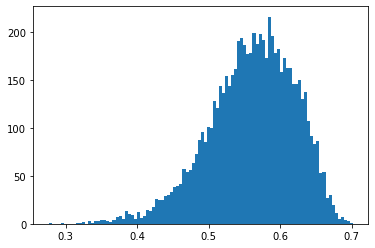

In [25]:
#day 7
plt.hist(corrs,bins=100);

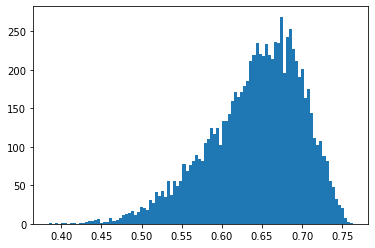

In [23]:
#day 3
plt.hist(corrs,bins = 100);

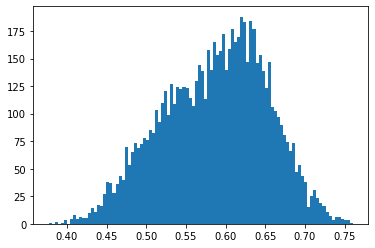

In [33]:
#day 7
plt.hist(corrs,bins=100);

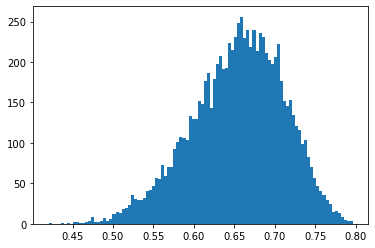

In [19]:
#day 3
plt.hist(corrs,bins=100);

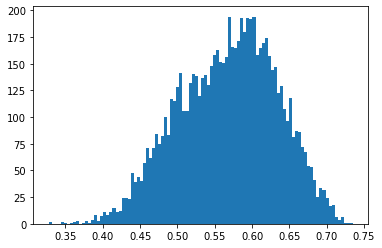

In [29]:
#day 7
plt.hist(corrs,bins=100);

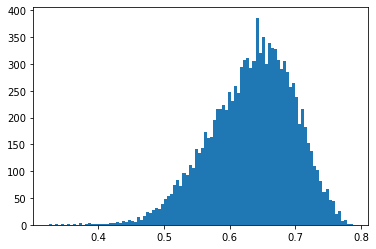

In [31]:
#day 3
plt.hist(corrs,bins=100);

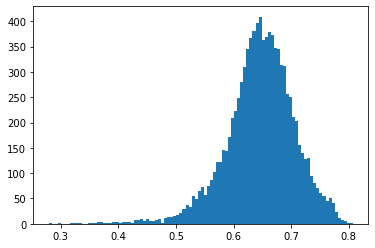

In [35]:
#7->2
plt.hist(corrs,bins=100);

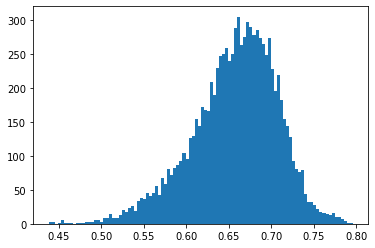

In [37]:
#7->4
plt.hist(corrs,bins=100);

In [5]:
mask_model2 = np.array(corrs)>0.57

In [6]:
len(mask_model2)

7656

In [7]:
mask_model2.sum()

3945

In [18]:
Y = Y[mask_model2]
X = X[mask_model2]
targets=targets[mask_model2]
evaluate(7,13176,loss=False,save=False)

24/24 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 6.039999961853027
Correlation = 0.66712
PCA Correlation = 0.98201
24/24 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 5.800000190734863
Correlation = 0.67073
PCA Correlation = 0.98285
24/24 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 5.869999885559082
Correlation = 0.66620
PCA Correlation = 0.98247
24/24 [==============================] - 0s 2ms/step

 --------- FOLD 3 -----------
Mean squared error = 6.010000228881836
Correlation = 0.66806
PCA Correlation = 0.98216
24/24 [==============================] - 0s 2ms/step

 --------- FOLD 4 -----------
Mean squared error = 5.800000190734863
Correlation = 0.66809
PCA Correlation = 0.98271
24/24 [==============================] - 0s 2ms/step

 --------- FOLD 5 -----------
Mean squared error = 5.980000019073486
Correlation = 0.66953


In [23]:
Y = Y[~mask_model2]
X = X[~mask_model2]
targets=targets[~mask_model2]
evaluate(7,13176,loss=False,save=False)

30/30 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 8.920000076293945
Correlation = 0.59918
PCA Correlation = 0.96697
30/30 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 8.729999542236328
Correlation = 0.60101
PCA Correlation = 0.96782
30/30 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 8.90999984741211
Correlation = 0.60096
PCA Correlation = 0.96711
Mean corr = 0.60039
Mean pca corr = 0.96730


In [24]:
(mask_model2.sum()*0.66829+(len(mask_model2)-mask_model2.sum())*0.60039)/len(mask_model2)

0.6421795124564693

In [26]:
evaluate(7,13176,loss=False,save=False)

78/78 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 7.309999942779541
Correlation = 0.64146
PCA Correlation = 0.97604
78/78 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 7.28000020980835
Correlation = 0.64124
PCA Correlation = 0.97622
78/78 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 7.25
Correlation = 0.64293
PCA Correlation = 0.97624
Mean corr = 0.64188
Mean pca corr = 0.97617


In [11]:
Y = Y[mask_model2]
X = X[mask_model2]
targets=targets[mask_model2]
evaluate(7,31800,loss=False,save=False)

42/42 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 6.0
Correlation = 0.65584
PCA Correlation = 0.98143
42/42 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 5.960000038146973
Correlation = 0.65725
PCA Correlation = 0.98166
42/42 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 6.019999980926514
Correlation = 0.65588
PCA Correlation = 0.98134
Mean corr = 0.65632
Mean pca corr = 0.98148


In [13]:
Y = Y[~mask_model2]
X = X[~mask_model2]
targets=targets[~mask_model2]
evaluate(7,31800,loss=False,save=False)

39/39 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 8.489999771118164
Correlation = 0.59320
PCA Correlation = 0.96806
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 8.59000015258789
Correlation = 0.59291
PCA Correlation = 0.96752
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 8.4399995803833
Correlation = 0.59324
PCA Correlation = 0.96800
Mean corr = 0.59312
Mean pca corr = 0.96786


In [14]:
(mask_model2.sum()*0.65632+(len(mask_model2)-mask_model2.sum())*0.59312)/len(mask_model2)

0.6256858307210031

In [18]:
evaluate(7,31800,loss=False,save=False)

80/80 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 7.369999885559082
Correlation = 0.62471
PCA Correlation = 0.97460
80/80 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 7.429999828338623
Correlation = 0.62585
PCA Correlation = 0.97447
80/80 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 7.369999885559082
Correlation = 0.62590
PCA Correlation = 0.97470
Mean corr = 0.62549
Mean pca corr = 0.97459


In [27]:
meta.loc[(meta.day == 7)&(meta.donor == 13176)].cell_type.value_counts()

MasP    1751
NeuP    1733
MkP     1575
HSC     1282
EryP     900
MoP      224
BP         1
Name: cell_type, dtype: int64

In [6]:
import warnings
warnings.filterwarnings("ignore")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
i = 7
j = 13176
meta_small = meta.loc[(meta.day == i)&(meta.donor == j)]
meta_small['range'] = range(len(meta_small))
selector = {}
for k in ('MasP','NeuP','MkP','HSC','Rest'):
    if k != 'Rest':
        selector[k] = meta_small.loc[(meta.cell_type == k)].range.values
    else:
        selector[k] = meta_small.loc[((meta_small.cell_type == 'EryP')|(meta_small.cell_type == 'MoP'))].range.values

In [7]:
Y_copy = Y.copy()

In [19]:
meta['range'] = range(len(meta))
day7_donor2 = meta.loc[(meta.day == 7)&(meta.donor == 13176)].range.values

In [31]:
targets_copy.shape

(105942, 22858)

In [32]:
int_targets_copy = targets.copy()

In [33]:
for j in selector.keys():
    Y = Y_copy.copy()
    X = X_copy.copy()[day7_donor2]
    targets = int_targets_copy.copy()
    # thousand = np.random.permutation(range(len(X)))
    # X = X[thousand]
    # Y = Y[thousand]
    # targets = targets[thousand]
    Y = Y[selector[j]]
    X = X[selector[j]]
    targets = targets[selector[j]]
    print(j)
    evaluate(0,0,loss=False,save=False)

MasP
19/19 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 8.989999771118164
Correlation = 0.61662
PCA Correlation = 0.96874
19/19 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 8.609999656677246
Correlation = 0.61929
PCA Correlation = 0.97034
19/19 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 8.84000015258789
Correlation = 0.62210
PCA Correlation = 0.96957
Mean corr = 0.61934
Mean pca corr = 0.96955
NeuP
19/19 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 8.0600004196167
Correlation = 0.61642
PCA Correlation = 0.97223
19/19 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 8.279999732971191
Correlation = 0.61433
PCA Correlation = 0.97143
19/19 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squar

In [34]:
#c.f. Mean corr = 0.64188
abc = [0.61934,0.61583,0.67962,0.63868,0.66366]
total = 0
lengths = 0
for n,j in enumerate(selector.keys()):
    total += len(selector[j])*abc[n]
    lengths += len(selector[j])
total/lengths

0.6412378874748828

In [5]:
day = 7
donor = 13176
for k in ('MasP','NeuP','MkP','HSC','Rest'):
    if k != 'Rest':
        selector = meta.loc[(meta.day == day)&(meta.donor == donor)&(meta.cell_type == k)].range.values
    else:
        selector = meta.loc[(meta.day == day)&(meta.donor == donor)&((meta.cell_type == 'EryP')|(meta.cell_type == 'MoP'))].range.values
    targets = targets_copy.copy()
    X = X_copy.copy()
    targets = targets[selector]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy[selector]
    print(k)
    evaluate(0,0,loss=False,save=False)

MasP
19/19 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 17.440000534057617
Correlation = 0.61770
PCA Correlation = 0.94064
19/19 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 17.100000381469727
Correlation = 0.62013
PCA Correlation = 0.94209
19/19 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 17.06999969482422
Correlation = 0.62307
PCA Correlation = 0.94224
Mean corr = 0.62030
Mean pca corr = 0.94166
NeuP
19/19 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 17.219999313354492
Correlation = 0.61689
PCA Correlation = 0.94065
19/19 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 17.520000457763672
Correlation = 0.61481
PCA Correlation = 0.93977
19/19 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mea

In [7]:
#c.f. Mean corr = 0.64188
abc = [0.62030,0.61627,0.68074,0.63953,0.66553]
total = 0
lengths = 0
for n,j in enumerate(selector.keys()):
    total += len(selector[j])*abc[n]
    lengths += len(selector[j])
total/lengths

0.6422290542531814

In [8]:
day4_donor2 = meta.loc[(meta.day == 4)&(meta.donor == 13176)]

In [9]:
day4_donor2.cell_type.value_counts()

HSC     2975
NeuP    1967
EryP    1707
MasP    1444
MkP     1165
MoP      116
BP        33
Name: cell_type, dtype: int64

In [10]:
day4_ratios = day4_donor2.cell_type.value_counts()/len(day4_donor2)

In [34]:
day7_donor2 = meta.loc[(meta.day == 7)&(meta.donor == 13176)].range.values

In [19]:
meta.loc[(meta.day == 7)&(meta.donor == 13176)].cell_type.value_counts()

MasP    1751
NeuP    1733
MkP     1575
HSC     1282
EryP     900
MoP      224
BP         1
Name: cell_type, dtype: int64

In [20]:
target = (day4_ratios*3000).astype(int).to_dict()

In [21]:
target

{'HSC': 948,
 'NeuP': 627,
 'EryP': 544,
 'MasP': 460,
 'MkP': 371,
 'MoP': 36,
 'BP': 10}

In [22]:
target['BP'] = 1

In [28]:
resampled_day7_donor2 = np.array([])
for i,j in target.items():
    to_sample = meta.loc[(meta.day == day)&(meta.donor == donor)&(meta.cell_type == i)].range.values
    resampled_day7_donor2 = np.append(resampled_day7_donor2,to_sample[np.random.choice(len(to_sample), size=j, replace=False)])

In [29]:
resampled_day7_donor2.shape

(2987,)

In [30]:
np.sum(list(target.values()))

2987

In [31]:
resampled_day7_donor2 = resampled_day7_donor2.astype(int)

In [32]:
resampled_day7_donor2

array([67399, 62585, 68711, ..., 67299, 66283, 63736])

In [33]:
#c.f. Mean corr = 0.64188
targets = targets_copy.copy()
X = X_copy.copy()
targets = targets[resampled_day7_donor2]
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)
targets = np.array(targets)
svd = TruncatedSVD(n_components = 512,random_state = 1)
Y = svd.fit_transform(targets)[:,:64]
X = X_copy[resampled_day7_donor2]
evaluate(0,0,loss=False,save=False)

32/32 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 13.170000076293945
Correlation = 0.63278
PCA Correlation = 0.95687
32/32 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 11.850000381469727
Correlation = 0.63685
PCA Correlation = 0.96080
32/32 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 18.6299991607666
Correlation = 0.63283
PCA Correlation = 0.93790
Mean corr = 0.63416
Mean pca corr = 0.95186


In [36]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 5)
X = X_copy.copy()
X = X[day7_donor2]
kmeans.fit(X)

KMeans(n_clusters=5)

In [42]:
pd.Series(kmeans.labels_).value_counts()

1    2651
0    1422
3    1283
2    1148
4     962
dtype: int64

In [43]:
day = 7
donor = 13176
for k in range(5):
    selector = kmeans.labels_ == k
    targets = targets_copy.copy()
    targets = targets[day7_donor2]
    targets = targets[selector]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy.copy()
    X = X[day7_donor2]
    X = X[selector]
    print(k)
    evaluate(0,0,loss=False,save=False)

0
15/15 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 19.3700008392334
Correlation = 0.61757
PCA Correlation = 0.93468
15/15 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 19.329999923706055
Correlation = 0.61887
PCA Correlation = 0.93480
15/15 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 19.270000457763672
Correlation = 0.62137
PCA Correlation = 0.93539
Mean corr = 0.61927
Mean pca corr = 0.93496
1
28/28 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 12.050000190734863
Correlation = 0.63071
PCA Correlation = 0.95901
28/28 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 12.390000343322754
Correlation = 0.62896
PCA Correlation = 0.95782
28/28 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squar

In [50]:
#c.f. Mean corr = 0.64188
abc = [0.61927,0.63052,0.63085,0.68323,0.66753]
lengths = pd.Series(kmeans.labels_).value_counts().sort_index().values
total = 0.
for i in range(5):
    total += lengths[i]*abc[i]
total /= lengths.sum()
total

0.6422547830163408

In [54]:
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0]]

In [56]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 5)
X = X_copy.copy()
X = X[day7_donor2]
kmeans.fit(X)

KMeans(n_clusters=5)

In [57]:
pd.Series(kmeans.labels_).value_counts()

1    2650
4    1408
2    1280
0    1158
3     970
dtype: int64

In [60]:
multi_train_x = scipy.sparse.load_npz("./sparse/train_multi_inputs_values.sparse.npz")

In [69]:
multi_train_x.shape

(105942, 228942)

In [61]:
kmeans = KMeans(n_clusters = 5)
X = multi_train_x[day7_donor2]
kmeans.fit(X)

KMeans(n_clusters=5)

In [62]:
pd.Series(kmeans.labels_).value_counts()

2    4989
1    2474
0       1
3       1
4       1
dtype: int64

In [63]:
day = 7
donor = 13176
for k in range(5):
    if k not in (1,2):
        continue
    selector = kmeans.labels_ == k
    targets = targets_copy.copy()
    targets = targets[day7_donor2]
    targets = targets[selector]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy.copy()
    X = X[day7_donor2]
    X = X[selector]
    print(k)
    evaluate(0,0,loss=False,save=False)

1
26/26 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 13.460000038146973
Correlation = 0.67418
PCA Correlation = 0.96079
26/26 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 13.229999542236328
Correlation = 0.67358
PCA Correlation = 0.96142
26/26 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 13.319999694824219
Correlation = 0.67304
PCA Correlation = 0.96078
Mean corr = 0.67360
Mean pca corr = 0.96100
2
52/52 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 9.760000228881836
Correlation = 0.62374
PCA Correlation = 0.96661
52/52 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 9.760000228881836
Correlation = 0.62302
PCA Correlation = 0.96652
52/52 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squar

In [65]:
#c.f. Mean corr = 0.64188
abc = [0.67360,0.62412]
lengths = [2474,4989]
total = 0.
for i in range(2):
    total += lengths[i]*abc[i]
total /= np.sum(lengths)
total

0.6405227227656439

In [67]:
day = 7
donor = 13176
for k in range(5):
    if k not in (1,2):
        continue
    selector = kmeans.labels_ == k
    targets = targets_copy.copy()
    targets = targets[day7_donor2]
    targets = targets[selector]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:512]
    X = X_copy.copy()[:,:40]
    X = X[day7_donor2]
    X = X[selector]
    print(k)
    evaluate(0,0,loss=False,save=False)

1
26/26 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 12.25
Correlation = 0.67642
PCA Correlation = 0.96403
26/26 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 12.1899995803833
Correlation = 0.67558
PCA Correlation = 0.96428
26/26 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 12.180000305175781
Correlation = 0.67533
PCA Correlation = 0.96404
Mean corr = 0.67578
Mean pca corr = 0.96412
2
52/52 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 8.979999542236328
Correlation = 0.62526
PCA Correlation = 0.96900
52/52 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 9.100000381469727
Correlation = 0.62439
PCA Correlation = 0.96869
52/52 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 8.92

In [68]:
#c.f. Mean corr = 0.64188
abc = [0.67578,0.62554]
lengths = [2474,4989]
total = 0.
for i in range(2):
    total += lengths[i]*abc[i]
total /= np.sum(lengths)
total

0.6421946643440976

In [112]:
abc = pd.Series(kmeans.labels_).value_counts().sort_index()
abc = pd.DataFrame(abc,columns=['size'])
abc['correlation'] = [0,0.67578,0.62554,0,0]
abc['64 PCA'] = [0,0.96412,0.96897,0,0]
abc['512 PCA'] = [0,0.82946,0.84374,0,0]
abc['1024 PCA'] = [0,0.75209,0.76559,0,0]
abc['2048 PCA'] = [0,0.67592,0.68293,0,0]
abc['4096 PCA'] = [0,0.66030,0.62151,0,0]

In [113]:
abc

,size,correlation,64 PCA,512 PCA,1024 PCA,2048 PCA,4096 PCA
0,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,2474,0.67578,0.96412,0.82946,0.75209,0.67592,0.66030
2,4989,0.62554,0.96897,0.84374,0.76559,0.68293,0.62151
3,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [ ]:
kmeans = KMeans(n_clusters = 5)
X = multi_train_x[day7_donor2]
kmeans.fit(X)

In [92]:
day = 7
donor = 13176
for k in range(5):
    if k != 2:
        continue
    selector = kmeans.labels_ == k
    targets = targets_copy.copy()
    targets = targets[day7_donor2]
    targets = targets[selector]
    targets = targets[:1000]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy.copy()[:,:40]
    X = X[day7_donor2]
    X = X[selector]
    X = X[:1000]
    print(k)
    evaluate(0,0,loss=False,save=False)

2
11/11 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 23.0
Correlation = 0.62557
PCA Correlation = 0.92541
11/11 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 22.760000228881836
Correlation = 0.62557
PCA Correlation = 0.92661
11/11 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 24.25
Correlation = 0.62082
PCA Correlation = 0.92095
Mean corr = 0.62398
Mean pca corr = 0.92432


In [100]:
day = 7
donor = 13176
for k in range(5):
    if k not in (1,2):
        continue
    selector = kmeans.labels_ == k
    targets = targets_copy.copy()
    targets = targets[day7_donor2]
    targets = targets[selector]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:512]
    X = X_copy.copy()[:,:40]
    X = X[day7_donor2]
    X = X[selector]
    print(k)
    evaluate(0,0,loss=False,save=False)

1
26/26 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 9.0600004196167
Correlation = 0.67100
PCA Correlation = 0.83026
26/26 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 9.119999885559082
Correlation = 0.67027
PCA Correlation = 0.82915
26/26 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 9.119999885559082
Correlation = 0.66971
PCA Correlation = 0.82898
Mean corr = 0.67033
Mean pca corr = 0.82946
2
52/52 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 6.940000057220459
Correlation = 0.62174
PCA Correlation = 0.84321
52/52 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 6.960000038146973
Correlation = 0.62110
PCA Correlation = 0.84269
52/52 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared er

In [ ]:
day = 7
donor = 13176
for k in range(5):
    if k != 2:
        continue
    selector = kmeans.labels_ == k
    targets = targets_copy.copy()
    targets = targets[day7_donor2]
    targets = targets[selector]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 2048,random_state = 1)
    Y = svd.fit_transform(targets)[:,:2048]
    X = X_copy.copy()[:,:40]
    X = X[day7_donor2]
    X = X[selector]
    print(k)
    evaluate(0,0,loss=False,save=False)

In [130]:
day = 4
donor = 13176
for k in ('MasP','NeuP','MkP','HSC','Rest'):
    if k != 'Rest':
        selector = meta.loc[(meta.day == day)&(meta.donor == donor)&(meta.cell_type == k)].range.values
    else:
        selector = meta.loc[(meta.day == day)&(meta.donor == donor)&((meta.cell_type == 'EryP')|(meta.cell_type == 'MoP'))].range.values
    targets = targets_copy.copy()
    X = X_copy.copy()
    targets = targets[selector]
    # Normalize the targets row-wise: This doesn't change the correlations,
    # and negative_correlation_loss depends on it
    targets -= targets.mean(axis=1).reshape(-1, 1)
    targets /= targets.std(axis=1).reshape(-1, 1)
    targets = np.array(targets)
    svd = TruncatedSVD(n_components = 512,random_state = 1)
    Y = svd.fit_transform(targets)[:,:64]
    X = X_copy[selector]
    print(k)
    evaluate(0,0,loss=False,save=False)

MasP
16/16 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 17.920000076293945
Correlation = 0.68638
PCA Correlation = 0.95019
16/16 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 17.309999465942383
Correlation = 0.68859
PCA Correlation = 0.95268
16/16 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 17.969999313354492
Correlation = 0.68785
PCA Correlation = 0.95024
Mean corr = 0.68760
Mean pca corr = 0.95104
NeuP
21/21 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 14.609999656677246
Correlation = 0.68503
PCA Correlation = 0.95871
21/21 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 14.510000228881836
Correlation = 0.68639
PCA Correlation = 0.95885
21/21 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Me

In [135]:
cell_types = ('MasP','NeuP','MkP','HSC','Rest')
day7_donor2 = meta.loc[(meta.day == 7)&(meta.donor == 13176)].range.values
abc = meta.iloc[day7_donor2].cell_type.value_counts()
abc = pd.DataFrame(abc).rename(columns={'cell_type':'cell count'})
abc['day 7 corr'] = [0.62030,0.61627,0.68074,0.63953,0.66553,0.66553,0.66553]
abc['day 4 corr'] = [0.68760,0.68479,0.68854,0.68380,0.69479,0.69479,0.69479]
abc

,cell count,day 7 corr,day 4 corr
MasP,1751,0.62030,0.68760
NeuP,1733,0.61627,0.68479
MkP,1575,0.68074,0.68854
HSC,1282,0.63953,0.68380
EryP,900,0.66553,0.69479
MoP,224,0.66553,0.69479
BP,1,0.66553,0.69479


In [6]:
with open('../input/targets-multiome-sparse-scaled/train_Citeseq_truncated_512.pkl','rb') as f: X = pickle.load(f)
with open('../input/targets-multiome-sparse-scaled/test_Citeseq_truncated_512.pkl','rb') as f: Xt = pickle.load(f)

X.shape, Xt.shape

Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
#Y = Y.loc[meta.day == 3]
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y.shape

X0 = np.genfromtxt('./sparse/X0.csv',delimiter=',')

X = np.hstack((X[:,:75],X0))
X.shape
X_copy = X.copy()
Y_copy = Y.copy()

In [7]:
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="citeseq"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
for i in (2,3,4):
    for j in (32606,13176,31800):
        selector[(i,j)] = meta.loc[(meta.day == i)&(meta.donor == j)].range.values

In [ ]:
corr_scores = []
lengths = 0
for i in (2,3,4):
    for j in (32606,13176,31800):
        for fold in range(3):
            model = load_model(f"./cite_model_saves/model_{i}_{j}_{fold}",
                custom_objects={'negative_correlation_loss': negative_correlation_loss})
            for k in (32606,13176,31800):
                if j!=k:
                    corr_scores.append(correlation_score(Y[selector[(i,k)]],model.predict(X[selector[(i,k)]])))
                    lengths += 1
corr_scores.sum()/lengths

In [66]:
np.sum(corr_scores)/lengths

0.8840398745690025

(array([ 3.,  6.,  0.,  3.,  3.,  7.,  5., 14.,  8.,  5.]),
 array([0.86387628, 0.86719716, 0.87051803, 0.87383891, 0.87715978,
        0.88048066, 0.88380153, 0.8871224 , 0.89044328, 0.89376415,
        0.89708503]),
 <BarContainer object of 10 artists>)

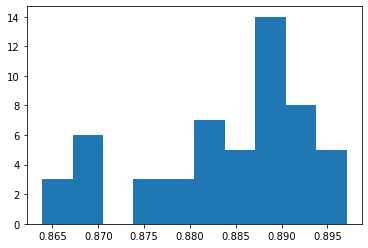

In [68]:
plt.hist(corr_scores)

In [69]:
import warnings
warnings.filterwarnings("ignore")

with np.load('./sparse/train_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_multi_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="multiome"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
for i in (2,3,4,7):
    for j in (32606,13176,31800):
        selector[(i,j)] = meta.loc[(meta.day == i)&(meta.donor == j)].range.values

In [70]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]

In [75]:
targets_copy = targets_copy.toarray()

In [76]:
corr_scores = []
lengths = 0
for i in (2,3,4,7):
    for j in (32606,13176,31800):
        svds = np.load(f"./multi_model_saves/model_{i}_{j}_svds.npy")
        for fold in range(3):
            model = load_model(f"./multi_model_saves/model_{i}_{j}_{fold}",
                custom_objects={'negative_correlation_loss': negative_correlation_loss})
            for k in (32606,13176,31800):
                if j!=k:
                    corr_scores.append(correlation_score(targets_copy[selector[(i,k)]],model.predict(X_copy[selector[(i,k)]])@svds))
                    lengths += 1

234/234 [==============================] - 1s 2ms/step


In [77]:
np.sum(corr_scores)/lengths

0.6611708342571032

(array([12.,  0.,  6.,  0.,  0.,  0.,  6.,  9.,  9., 30.]),
 array([0.60970338, 0.61725756, 0.62481174, 0.63236592, 0.6399201 ,
        0.64747427, 0.65502845, 0.66258263, 0.67013681, 0.67769099,
        0.68524517]),
 <BarContainer object of 10 artists>)

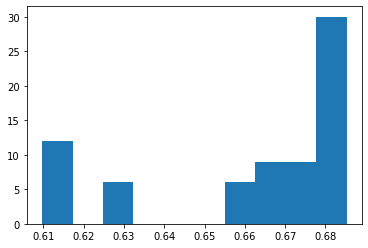

In [78]:
plt.hist(corr_scores)

In [ ]:
0.655, 0.890 on fourth donor (0.661 and 0.339)
or
0.685, 0.873 on fourth donor (0.667 and 0.333)
expected at least 0.890 and 0.680 so some mistake?
0.682, 0.895
my average other-donor prediction is
0.661, 0.884
so 0.655, 0.890 is not too far off

In [10]:
pred = np.zeros((len(X_copy[selector[(2,31800)]]),140))
for fold in range(3):
    model = load_model(f"./cite_model_saves/model_2_32606_{fold}",
        custom_objects={'negative_correlation_loss': negative_correlation_loss})
    pred =+ model.predict(X_copy[selector[(2,31800)]])

2022-11-09 20:03:01.717163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 20:03:01.725884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-09 20:03:01.725905: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-09 20:03:01.726325: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

263/263 [==============================] - 1s 3ms/step


In [11]:
correlation_score(Y_copy[selector[(2,31800)]],pred)

0.893370414788536

In [13]:
abc = np.load('./corrs/cite_all_corrs.npy')

In [18]:
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS).drop(columns = constant_cols)

Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
#Y = Y.loc[meta.day == 3]
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y.shape
X_copy = X.values.copy()
Y_copy = Y.copy()

In [21]:
def evaluate(i,j,kind,save,loss=None):
    if (loss == None)&(kind=='multi'):
        loss = 'mse'
    elif (loss == None)&(kind=='cite'):
        loss = negative_correlation_loss
    assert(loss in ('mse',negative_correlation_loss))
    assert(kind in ('multi','cite'))
    VERBOSE = 0
    if kind == 'cite':
        N_SPLIT = 6
    else:
        N_SPLIT = 3
    #kf = KFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
    kf = KFold(n_splits = N_SPLIT)

    scores = []
    pca_scores = []
    Y_pred = np.zeros_like(Y)
    models = []

    for fold,(idx_tr, idx_va) in enumerate(kf.split(X)):

        X_tr = X[idx_tr]
        y_tr = Y[idx_tr]

        X_va = X[idx_va]
        y_va = Y[idx_va] 

        model = create_model(X.shape[1],Y.shape[1])

        lr = ReduceLROnPlateau(
                    monitor = "val_loss",
                    factor = 0.9, 
                    patience = 4, 
                    verbose = VERBOSE)

        es = EarlyStopping(
                    monitor = "val_loss",
                    patience = 30, 
                    verbose = VERBOSE,
                    mode = "min", 
                    restore_best_weights = True)

        if kind == 'cite':
            chk = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './cite',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)
        else:
            chk = tf.keras.callbacks.ModelCheckpoint(
                    filepath = './multi',
                    save_weights_only = True,
                    monitor = 'val_loss',
                    mode = 'min',
                    save_best_only = True)

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                      loss = loss,
                      metrics = loss)
            
        model.fit(X_tr,
                  y_tr,
                  validation_data=(X_va,y_va),
                  epochs =500,
                  verbose = VERBOSE,
                  batch_size=256,
                  callbacks = [es,lr,chk]
                 )
        y_va_pred = model.predict(X_va)
        Y_pred[idx_va] = y_va_pred
        if kind == 'cite':
            corrscore = correlation_score(y_va, y_va_pred)
            scores.append(corrscore)
        else:
            corrscore = correlation_score(targets[idx_va], y_va_pred@svd.components_[:64])
            scores.append(corrscore)
            pca_corrscore = correlation_score(y_va[:,:64], y_va_pred[:,:64])
            pca_scores.append(pca_corrscore)

        if kind == 'cite':    
            model.fit(X_va,
                  y_va,
                  epochs=20,
                  verbose = VERBOSE,
                  batch_size=256
                 )    
            
        models.append(model)
        
        print(f'\n --------- FOLD {fold} -----------')
        print(f'Mean squared error = {np.round(mean_squared_error(y_va,y_va_pred),2)}')
        print(f'Correlation = {corrscore:.5f}')
        if kind == 'multi':
            print(f'PCA Correlation = {pca_corrscore:.5f}')
        if kind == 'cite':
            filename = f"./cite_model_saves/model_{i}_{j}_{fold}"
        else:
            filename = f"./multi_model_saves/model_{i}_{j}_{fold}"
        if save:
            model.save(filename)
            print('model saved :',filename)

        del X_tr,X_va,y_tr,y_va
        gc.collect()

    # Show overall score
    print(f"{Fore.GREEN}{Style.BRIGHT}Mean corr = {np.array(scores).mean():.5f}{Style.RESET_ALL}")
    if not loss:
        print(f"{Fore.RED}{Style.BRIGHT}Mean pca corr = {np.array(pca_scores).mean():.5f}{Style.RESET_ALL}")
    return models

In [22]:
LR_START = 0.01
BATCH_SIZE = 512

def create_model(input_shape, output_shape):
    
    reg1 = 9.613e-06
    reg2 = 1e-07
    REG1 = tf.keras.regularizers.l2(reg1)
    REG2 = tf.keras.regularizers.l2(reg2)
    DROP = 0.1

    activation = 'selu'
    inputs = Input(shape =(input_shape,))

    x0 = Dense(256, 
              kernel_regularizer = REG1,
              activation = activation,
             )(inputs)
    x0 = Dropout(DROP)(x0)
    
    
    x1 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x0)
    x1 = Dropout(DROP)(x1)
    
    
    x2 = Dense(512, 
               kernel_regularizer = REG1,
               activation = activation,
             )(x1) 
    x2= Dropout(DROP)(x2)
    
    x3 = Dense(output_shape,
               kernel_regularizer = REG1,
               activation = activation,
             )(x2)
    x3 = Dropout(DROP)(x3)

         
    x = Concatenate()([
                x0, 
                x1, 
                x2, 
                x3
                ])
    
    x = Dense(output_shape, 
                kernel_regularizer = REG2,
                activation='linear',
                )(x)
    
    
    model = Model(inputs, x)
    

    return model

In [23]:
Y = Y_copy.copy()
X = X_copy.copy()
Y = Y[selector[(i,j)]][:,0].reshape(-1,1)
X = X[selector[(i,j)]][:,abc[0]]
evaluate(i,j,'cite',loss='mse',save=False)

53/53 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 0 -----------
Mean squared error = 0.15000000596046448
Correlation = nan
53/53 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 1 -----------
Mean squared error = 0.1599999964237213
Correlation = nan
53/53 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 2 -----------
Mean squared error = 0.1599999964237213
Correlation = nan
53/53 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 3 -----------
Mean squared error = 0.1599999964237213
Correlation = nan
53/53 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 4 -----------
Mean squared error = 0.1599999964237213
Correlation = nan
53/53 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 5 -----------
Mean squared error = 0.17000000178813934
Correlation = nan
Mean corr = nan


In [29]:
X = X_copy[selector[(2,32606)]][:,all_corrs.ravel()]
Y = Y_copy[selector[(2,32606)]]
X_test = X_copy[selector[(2,31800)]][:,all_corrs.ravel()]
evaluate(i,j,'cite',loss='mse',save=False)

39/39 [==============================] - 0s 7ms/step

 --------- FOLD 0 -----------
Mean squared error = 0.3400000035762787
Correlation = 0.81262


KeyboardInterrupt: 

In [30]:
X = X_copy[selector[(2,32606)]][:,all_corrs.ravel()]
Y = Y_copy[selector[(2,32606)]]
X_test = X_copy[selector[(2,31800)]][:,all_corrs.ravel()]
evaluate(i,j,'cite',save=False)

39/39 [==============================] - 0s 7ms/step

 --------- FOLD 0 -----------
Correlation = 0.89139
39/39 [==============================] - 0s 7ms/step

 --------- FOLD 1 -----------
Correlation = 0.89315
39/39 [==============================] - 0s 7ms/step

 --------- FOLD 2 -----------
Correlation = 0.89378


KeyboardInterrupt: 

In [31]:
(0.89378+0.89315+0.89139)/3

0.8927733333333333

In [120]:
with open('../input/targets-multiome-sparse-scaled/train_Citeseq_truncated_512.pkl','rb') as f: X = pickle.load(f)
with open('../input/targets-multiome-sparse-scaled/test_Citeseq_truncated_512.pkl','rb') as f: Xt = pickle.load(f)

X.shape, Xt.shape

Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
#Y = Y.loc[meta.day == 3]
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y.shape

X0 = np.genfromtxt('./sparse/X0.csv',delimiter=',')

X = np.hstack((X[:,:75],X0))
X.shape
X_copy = X.copy()
Y_copy = Y.copy()

In [119]:
pred = np.zeros((len(X_copy[selector[(2,31800)]]),140))
for i in range(6):
    model = load_model(f"./cite_model_saves/model_2_32606_{i}",
        custom_objects={'negative_correlation_loss': negative_correlation_loss})
    pred =+ model.predict(X_copy[selector[(2,31800)]])
pred

263/263 [==============================] - 1s 2ms/step


array([[ -8.341819 ,  -7.000804 ,  -5.936493 , ...,  -7.8296666,
         19.201    ,  -0.5561965],
       [-10.562783 , -10.471197 ,  -9.601033 , ..., -10.04439  ,
         -3.3990626,  -5.8704944],
       [ -8.153778 ,  -8.231568 ,  -7.3324304, ...,  -7.3950114,
         -4.5542154,  -5.253058 ],
       ...,
       [ -8.621112 ,  -7.162931 ,  -5.632567 , ...,  -7.615811 ,
          0.3384807,  -4.108725 ],
       [ -4.050392 ,  -3.6534047,  -4.0891604, ...,  -3.8050156,
          2.8783886,  -1.2394468],
       [ -9.494724 ,  -9.221361 ,  -8.041249 , ...,  -9.031226 ,
         -1.3839644,  -4.5863323]], dtype=float32)

In [36]:
pred -= pred.mean(axis=1).reshape(-1, 1)
pred /= pred.std(axis=1).reshape(-1, 1)

In [48]:
mean_squared_error(Y_copy[selector[(2,31800)]],pred)

7.4331307

In [20]:
len(list(map(lambda x:x**2,diff)))

8395

In [121]:
correlation_score(Y_copy[selector[(2,31800)]],pred)

0.8914866724925634

In [ ]:
correlation_score(

SyntaxError: unexpected EOF while parsing (856507758.py, line 1)

In [22]:
(Y_copy[selector[(2,31800)]] - pred)**2

(array([ 1.,  4.,  3.,  6.,  8.,  7., 85., 23.,  1.,  2.]),
 array([0.49344745, 0.569669  , 0.64589053, 0.72211206, 0.7983336 ,
        0.8745551 , 0.95077664, 1.0269982 , 1.1032197 , 1.1794412 ,
        1.2556628 ], dtype=float32),
 <BarContainer object of 10 artists>)

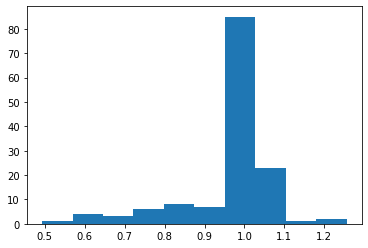

In [8]:
diff = Y_copy[selector[(2,31800)]] - pred
abc = np.sqrt(np.mean(list(map(lambda x:x**2,diff)),axis=0))
plt.hist(abc/np.std(Y_copy[selector[(2,31800)]],axis=0))

In [9]:
np.sqrt(np.mean(list(map(lambda x:x**2,diff))))


0.46601555

In [85]:
with open('../input/targets-multiome-sparse-scaled/train_Citeseq_truncated_512.pkl','rb') as f: X = pickle.load(f)
with open('../input/targets-multiome-sparse-scaled/test_Citeseq_truncated_512.pkl','rb') as f: Xt = pickle.load(f)

Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
Y = Y.values

X0 = np.genfromtxt('./sparse/X0.csv',delimiter=',')

X = np.hstack((X[:,:75],X0))
X.shape
X_copy = X.copy()
Y_copy = Y.copy()

In [10]:
Y = Y_copy.copy()
X = X_copy.copy()
Y = Y[selector[(2,32606)]]
X = X[selector[(2,32606)]]
evaluate('temp','temp','cite',loss='mse',save=True)

39/39 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 1.9299999475479126
Correlation = 0.89272
model saved : ./cite_model_saves/model_temp_temp_0
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 1.9199999570846558
Correlation = 0.89339
model saved : ./cite_model_saves/model_temp_temp_1
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 1.9199999570846558
Correlation = 0.89474
model saved : ./cite_model_saves/model_temp_temp_2
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 3 -----------
Mean squared error = 1.9500000476837158
Correlation = 0.89295
model saved : ./cite_model_saves/model_temp_temp_3
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 4 -----------
Mean squared error = 1.9199999570846558
Correlation = 0.89480
model saved : ./cite_model_saves/model_temp_temp_4
39/39 [========

In [87]:
Y = Y_copy.copy()
X = X_copy.copy()
Y = Y[selector[(2,32606)]]
X = X[selector[(2,32606)]]
evaluate('temp','temp','cite',loss='mse',save=False)

39/39 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 1.940000057220459
Correlation = 0.89184


KeyboardInterrupt: 

In [70]:
X_test = X_copy[selector[(2,31800)]]
preds = np.zeros((len(X_test),140))

for i in range(6):
    model = load_model(f"./cite_model_saves/model_temp_temp_2")
    preds+=model.predict(X_test)/6

263/263 [==============================] - 1s 2ms/step


In [71]:
preds

array([[ 0.16396908,  0.40501016,  1.78292942, ..., -0.58786905,
         9.3737061 ,  2.75640982],
       [ 0.07586134, -0.17109378,  0.78216326, ...,  0.44603629,
         1.64511913,  1.07513157],
       [ 0.91702455,  0.04434186,  0.17044335, ..., -0.18984888,
         1.80698419,  0.77311993],
       ...,
       [-0.43674029, -0.05477544,  0.88701019, ..., -0.14906801,
         2.42450452,  1.54628634],
       [ 0.3227571 ,  0.18039678,  0.49265769, ..., -0.50108381,
         3.92552984,  1.75103295],
       [-0.03539791,  0.01260125,  0.44222917, ...,  0.36872759,
         2.15343064,  1.29474807]])

In [72]:
correlation_score(Y_copy[selector[(2,31800)]],preds)

0.8856882177391285

(array([ 5.,  2.,  4.,  6.,  8., 15., 31., 61.,  7.,  1.]),
 array([0.57517246, 0.6405625 , 0.70595255, 0.7713426 , 0.83673265,
        0.90212269, 0.96751274, 1.03290279, 1.09829284, 1.16368288,
        1.22907293]),
 <BarContainer object of 10 artists>)

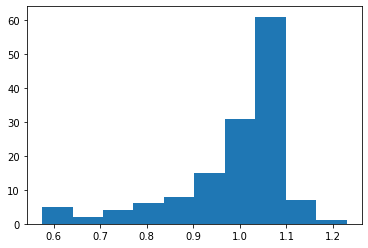

In [73]:
diff = Y_copy[selector[(2,31800)]] - preds
abc = np.sqrt(np.mean(list(map(lambda x:x**2,diff)),axis=0))
plt.hist(abc/np.std(Y_copy[selector[(2,31800)]],axis=0))

In [74]:
np.sqrt(np.mean(list(map(lambda x:x**2,diff))))

1.522737950117809

In [82]:
mean_squared_error(Y_copy[selector[(2,31800)]],preds)

2.3187308647290013

In [83]:
np.mean(list(map(lambda x:x**2,diff)))

2.318730864728987

In [9]:
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS).drop(columns = constant_cols)
Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
X = X.values
Y = Y.values
all_corrs = np.load('./corrs/cite_all_corrs.npy')
X_copy = X.copy()
Y_copy = Y.copy()

In [16]:
X_test = X_copy[selector[(2,31800)]][:,np.array(list(set(all_corrs.ravel())))]
X = X_copy[selector[(2,32606)]][:,np.array(list(set(all_corrs.ravel())))]
Y = Y_copy[selector[(2,32606)]]
evaluate('temp','mse','cite',loss='mse',save=True)

39/39 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 2.1700000762939453
Correlation = 0.88062
model saved : ./cite_model_saves/model_temp_mse_0
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 2.180000066757202
Correlation = 0.88232
model saved : ./cite_model_saves/model_temp_mse_1
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 2.1700000762939453
Correlation = 0.88294
model saved : ./cite_model_saves/model_temp_mse_2
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 3 -----------
Mean squared error = 2.2100000381469727
Correlation = 0.88241
model saved : ./cite_model_saves/model_temp_mse_3
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 4 -----------
Mean squared error = 2.2100000381469727
Correlation = 0.88342
model saved : ./cite_model_saves/model_temp_mse_4
39/39 [==============

In [17]:
preds = np.zeros((len(X_test),140))
for i in range(6):
    model = load_model(f"./cite_model_saves/model_temp_mse_{i}",
            custom_objects={'negative_correlation_loss': negative_correlation_loss})
    preds+=model.predict(X_test)/6
print(correlation_score(Y_copy[selector[(2,31800)]],preds))

263/263 [==============================] - 1s 2ms/step
0.8843626632486058


In [12]:
X_test = X_copy[selector[(2,31800)]][:,np.array(list(set(all_corrs.ravel())))]
X = X_copy[selector[(2,32606)]][:,np.array(list(set(all_corrs.ravel())))]
Y = Y_copy[selector[(2,32606)]]
evaluate('temp','temp','cite',save=True)

39/39 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 1647.9200439453125
Correlation = 0.89078
model saved : ./cite_model_saves/model_temp_temp_0
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 2918.760009765625
Correlation = 0.89271
model saved : ./cite_model_saves/model_temp_temp_1
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 1725.780029296875
Correlation = 0.89306
model saved : ./cite_model_saves/model_temp_temp_2
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 3 -----------
Mean squared error = 2796.580078125
Correlation = 0.89186
model saved : ./cite_model_saves/model_temp_temp_3
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 4 -----------
Mean squared error = 2167.0
Correlation = 0.89498
model saved : ./cite_model_saves/model_temp_temp_4
39/39 [==========================

In [116]:
preds = np.zeros((len(X_test),140))
for i in range(6):
    model = load_model(f"./cite_model_saves/model_temp_temp_{i}",
            custom_objects={'negative_correlation_loss': negative_correlation_loss})
    preds+=model.predict(X_test)/6
print(correlation_score(Y_copy[selector[(2,31800)]],preds))

263/263 [==============================] - 1s 2ms/step
0.8919404922189595


In [117]:
X = pd.read_hdf(FP_CITE_TRAIN_INPUTS).drop(columns = constant_cols)
Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
X = X.values
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
all_corrs = np.load('./corrs/cite_all_corrs.npy')
X_test = X[selector[(2,31800)]][:,np.array(list(set(all_corrs.ravel())))]
X = X[selector[(2,32606)]][:,np.array(list(set(all_corrs.ravel())))]
Y = Y[selector[(2,32606)]]
evaluate('temp','temp','cite',save=True)

39/39 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 971.0800170898438
Correlation = 0.89018
model saved : ./cite_model_saves/model_temp_temp_0
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 4460.2001953125
Correlation = 0.89193
model saved : ./cite_model_saves/model_temp_temp_1
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 1389.5799560546875
Correlation = 0.89205
model saved : ./cite_model_saves/model_temp_temp_2
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 3 -----------
Mean squared error = 705.9099731445312
Correlation = 0.89123
model saved : ./cite_model_saves/model_temp_temp_3
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 4 -----------
Mean squared error = 1309.0899658203125
Correlation = 0.89430
model saved : ./cite_model_saves/model_temp_temp_4
39/39 [=============

In [118]:
preds = np.zeros((len(X_test),140))
for i in range(6):
    model = load_model(f"./cite_model_saves/model_temp_temp_{i}",
            custom_objects={'negative_correlation_loss': negative_correlation_loss})
    preds+=model.predict(X_test)/6
print(correlation_score(Y_copy[selector[(2,31800)]],preds))

263/263 [==============================] - 1s 2ms/step
0.8913157627557553


In [55]:
with open('../input/targets-multiome-sparse-scaled/train_Citeseq_truncated_512.pkl','rb') as f: X = pickle.load(f)
with open('../input/targets-multiome-sparse-scaled/test_Citeseq_truncated_512.pkl','rb') as f: Xt = pickle.load(f)

Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
Y = Y.values

X0 = np.genfromtxt('./sparse/X0.csv',delimiter=',')

X = np.hstack((X[:,:75],X0))
X.shape
X_copy = X.copy()
Y_copy = Y.copy()

In [58]:
X.shape

(70988, 159)

In [62]:
Y = Y_copy.copy()
X = X_copy.copy()
Y = Y[selector[(2,32606)]][:,0].reshape(-1,1)
X = X[selector[(2,32606)]]
#X = X[selector[(2,32606)]][:,all_corrs[0]]
evaluate(i,j,'cite',loss='mse',save=False)

39/39 [==============================] - 0s 1ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 0 -----------
Mean squared error = 0.9300000071525574
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 1 -----------
Mean squared error = 1.0199999809265137
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 2 -----------
Mean squared error = 1.0700000524520874
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 3 -----------
Mean squared error = 1.059999942779541
Correlation = nan
39/39 [==============================] - 0s 1ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 4 -----------
Mean squared error = 1.0700000524520874
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 5 -----------
Mean squared error = 1.0
Correlation = nan
Mean corr = nan


In [66]:
X_copy = pd.read_hdf(FP_CITE_TRAIN_INPUTS).drop(columns = constant_cols)
Y_copy = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
X_copy = X_copy.values
Y_copy = Y_copy.values
all_corrs = np.load('./corrs/cite_all_corrs.npy')

In [67]:
Y = Y_copy.copy()
X = X_copy.copy()
Y = Y[selector[(2,32606)]][:,0].reshape(-1,1)
X = X[selector[(2,32606)]][:,all_corrs[0]]
evaluate(i,j,'cite',loss='mse',save=False)

39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 0 -----------
Mean squared error = 0.9300000071525574
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 1 -----------
Mean squared error = 0.9300000071525574
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 2 -----------
Mean squared error = 1.0399999618530273
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 3 -----------
Mean squared error = 1.0199999809265137
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 4 -----------
Mean squared error = 1.0199999809265137
Correlation = nan
39/39 [==============================] - 0s 2ms/step


/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/srv/conda/envs/saturn/lib/python3.9/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)



 --------- FOLD 5 -----------
Mean squared error = 0.9800000190734863
Correlation = nan
Mean corr = nan


In [34]:
targets_copy = scipy.sparse.load_npz("./sparse/train_multi_targets_values.sparse.npz")
targets_copy = scprep.filter.remove_empty_genes(targets_copy)
inputs_both_128 = np.load("./multi_pca/inputs_both_128.npy")
X_copy = inputs_both_128[:targets_copy.shape[0],:40]
i = 2
j = 32606
targets = targets_copy.copy()
X = X_copy.copy()
targets = targets[selector[(i,j)]]
# Normalize the targets row-wise: This doesn't change the correlations,
# and negative_correlation_loss depends on it
targets -= targets.mean(axis=1).reshape(-1, 1)
targets /= targets.std(axis=1).reshape(-1, 1)
targets = np.array(targets)
svd = TruncatedSVD(n_components = 512,random_state = 1)
Y = svd.fit_transform(targets)[:,:64]
X = X_copy[selector[(i,j)]]
models = evaluate(i,j,'multi',save=False,loss='mse')

38/38 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 6.300000190734863
Correlation = 0.69315
PCA Correlation = 0.98220
38/38 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 6.610000133514404
Correlation = 0.68937
PCA Correlation = 0.98117
38/38 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 6.539999961853027
Correlation = 0.69011
PCA Correlation = 0.98140
38/38 [==============================] - 0s 2ms/step

 --------- FOLD 3 -----------
Mean squared error = 6.539999961853027
Correlation = 0.68965
PCA Correlation = 0.98146
38/38 [==============================] - 0s 2ms/step

 --------- FOLD 4 -----------
Mean squared error = 6.53000020980835
Correlation = 0.68774
PCA Correlation = 0.98135
38/38 [==============================] - 0s 2ms/step

 --------- FOLD 5 -----------
Mean squared error = 6.630000114440918
Correlation = 0.68867
P

In [58]:
abc = models[0].predict(X_copy[selector[(2,31800)]])@svd.components_[:64]

222/222 [==============================] - 0s 2ms/step


In [59]:
abc.shape

(7089, 22858)

In [60]:
targets_copy[selector[(2,31800)]].shape

(7089, 22858)

In [64]:
for i in range(6):
    print(correlation_score(targets_copy[selector[(2,31800)]].toarray(),models[i].predict(X_copy[selector[(2,31800)]])@svd.components_[:64]))

222/222 [==============================] - 0s 2ms/step
0.6809086071575897
222/222 [==============================] - 0s 2ms/step
0.6808381362086735
222/222 [==============================] - 0s 2ms/step
0.6808579282752907
222/222 [==============================] - 0s 2ms/step
0.6808990728111387
222/222 [==============================] - 0s 2ms/step
0.6808973435077142
222/222 [==============================] - 0s 2ms/step
0.6807720542643249


In [66]:
with open('../input/targets-multiome-sparse-scaled/train_Citeseq_truncated_512.pkl','rb') as f: X = pickle.load(f)
with open('../input/targets-multiome-sparse-scaled/test_Citeseq_truncated_512.pkl','rb') as f: Xt = pickle.load(f)

X.shape, Xt.shape

Y = pd.read_hdf(FP_CITE_TRAIN_TARGETS)
#Y = Y.loc[meta.day == 3]
Y = Y.values
Y -= Y.mean(axis=1).reshape(-1, 1)
Y /= Y.std(axis=1).reshape(-1, 1)
Y.shape

X0 = np.genfromtxt('./sparse/X0.csv',delimiter=',')

X = np.hstack((X[:,:75],X0))
X.shape
X_copy = X.copy()
Y_copy = Y.copy()

In [71]:
i = 2
j = 32606
Y = Y_copy.copy()
X = X_copy.copy()
Y = Y[selector[(i,j)]]
X = X[selector[(i,j)]]
models = evaluate(i,j,'cite',save=False)

39/39 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 649.8499755859375
Correlation = 0.89589
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 672.9199829101562
Correlation = 0.89695
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 456.20001220703125
Correlation = 0.89766
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 3 -----------
Mean squared error = 510.739990234375
Correlation = 0.89756
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 4 -----------
Mean squared error = 542.0399780273438
Correlation = 0.89958
39/39 [==============================] - 0s 2ms/step

 --------- FOLD 5 -----------
Mean squared error = 691.530029296875
Correlation = 0.89824
Mean corr = 0.89765


In [72]:
for i in range(6):
    print(correlation_score(Y_copy[selector[(2,31800)]],models[i].predict(X_copy[selector[(2,31800)]])))

263/263 [==============================] - 0s 2ms/step
0.8946198536153431
263/263 [==============================] - 0s 2ms/step
0.8943206504407404
263/263 [==============================] - 0s 2ms/step
0.8942160977170116
263/263 [==============================] - 0s 2ms/step
0.8930096865052096
263/263 [==============================] - 0s 2ms/step
0.8950609237596935
263/263 [==============================] - 0s 2ms/step
0.8952847109098423


In [74]:
Y = Y_copy.copy()
X = X_copy.copy()
Y = Y[selector[(2,32606)]]
X = X[selector[(2,32606)]]
Y2 = Y_copy.copy()
X2 = X_copy.copy()
Y2 = Y2[selector[(2,13176)]]
X2 = X2[selector[(2,13176)]]
Y = np.vstack([Y,Y2])
X = np.vstack([X,X2])
models = evaluate(i,j,'cite',save=False)

71/71 [==============================] - 0s 2ms/step

 --------- FOLD 0 -----------
Mean squared error = 610.2899780273438
Correlation = 0.89685
71/71 [==============================] - 0s 2ms/step

 --------- FOLD 1 -----------
Mean squared error = 705.1699829101562
Correlation = 0.89779
71/71 [==============================] - 0s 2ms/step

 --------- FOLD 2 -----------
Mean squared error = 449.70001220703125
Correlation = 0.90070
71/71 [==============================] - 0s 2ms/step

 --------- FOLD 3 -----------
Mean squared error = 655.3400268554688
Correlation = 0.90347
71/71 [==============================] - 0s 2ms/step

 --------- FOLD 4 -----------
Mean squared error = 523.1799926757812
Correlation = 0.90555
71/71 [==============================] - 0s 2ms/step

 --------- FOLD 5 -----------
Mean squared error = 635.5399780273438
Correlation = 0.90801
Mean corr = 0.90206


In [75]:
for i in range(6):
    print(correlation_score(Y_copy[selector[(2,31800)]],models[i].predict(X_copy[selector[(2,31800)]])))

263/263 [==============================] - 0s 2ms/step
0.8981390326613323
263/263 [==============================] - 0s 2ms/step
0.8961839729423269
263/263 [==============================] - 0s 2ms/step
0.8988601492931795
263/263 [==============================] - 0s 2ms/step
0.8968793980664296
263/263 [==============================] - 0s 2ms/step
0.8929889259880025
263/263 [==============================] - 1s 2ms/step
0.8943401738657514


In [7]:
with np.load('./sparse/train_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index = data['index']
with np.load('./sparse/test_cite_inputs_idxcol.npz',allow_pickle=True) as data:
    cell_index_t = data['index']
metadata_df = pd.read_csv('../input/open-problems-multimodal/metadata.csv', index_col='cell_id')
metadata_df = metadata_df[metadata_df.technology=="citeseq"]
meta = metadata_df.reindex(cell_index)
meta['range'] = range(len(meta))
selector = {}
for i in (2,3,4):
    for j in (32606,13176,31800):
        selector[(i,j)] = meta.loc[(meta.day == i)&(meta.donor == j)].range.values

In [18]:
X_copy = pd.read_hdf(FP_CITE_TRAIN_INPUTS).drop(columns = constant_cols)
all_corrs = np.load('./corrs/cite_all_corrs.npy')
X_copy = X_copy.values

In [12]:
preds_800 = np.zeros((len(X_test),140))
for i in range(6):
    model = load_model(f"./cite_model_saves/model_800_2_32606_{i}",
            custom_objects={'negative_correlation_loss': negative_correlation_loss})
    preds_800+=model.predict(X_test)/6
print(correlation_score(Y_copy[selector[(2,31800)]],preds))

2022-11-15 17:46:03.544587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 17:46:03.552436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-15 17:46:03.552461: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-15 17:46:03.552902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow bin

318/318 [==============================] - 1s 2ms/step
0.864143022889884


In [ ]:
Y_copy[selector[(4,31800)]].shape

In [27]:
X_test = X_copy[selector[(4,31800)]]
preds_PCA = np.zeros((len(X_test),140))
for i in range(6):
    model = load_model(f"./cite_model_saves/model_4_32606_{i}",
            custom_objects={'negative_correlation_loss': negative_correlation_loss})
    preds_PCA+=model.predict(X_test)/6
print(correlation_score(Y_copy[selector[(4,31800)]],preds_PCA))

318/318 [==============================] - 1s 2ms/step
0.8712104148669244


In [28]:
X_test = X_copy[selector[(2,31800)]]
preds_PCA = np.zeros((len(X_test),140))
for i in range(6):
    model = load_model(f"./cite_model_saves/model_2_32606_{i}",
            custom_objects={'negative_correlation_loss': negative_correlation_loss})
    preds_PCA+=model.predict(X_test)/6
print(correlation_score(Y_copy[selector[(2,31800)]],preds_PCA))

263/263 [==============================] - 1s 2ms/step
0.8943475781025629
